# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# Импорт необходимых библиотек
import pandas as pd  # Pandas используется для работы с данными в виде таблиц
import numpy as np  # NumPy предоставляет функции для работы с числами и массивами
import seaborn as sns  # Seaborn - это библиотека для визуализации данных
import matplotlib.pyplot as plt  # Matplotlib - ещё одна библиотека для визуализации данных
import warnings  # Библиотека для управления предупреждениями в коде
import plotly.express as px  # Plotly Express - библиотека для создания интерактивных графиков
import plotly.figure_factory as ff  # Plotly Figure Factory - для создания разных типов графиков
from pylab import rcParams  # Настройка параметров графиков
from IPython.display import display  # Для отображения результатов в Jupyter Notebook
from termcolor import colored  # Для добавления цвета в текст

# Импорт библиотек для обучения моделей
from sklearn.model_selection import GridSearchCV  # Поиск оптимальных параметров модели
from sklearn.model_selection import cross_val_score  # Перекрёстная проверка модели
from sklearn.model_selection import train_test_split  # Разделение данных на обучающий и тестовый наборы
from sklearn.utils import shuffle  # Перемешивание данных

from sklearn.linear_model import LinearRegression  # Линейная регрессия - один из методов машинного обучения

# Импорт метрик для оценки моделей
from sklearn.metrics import make_scorer  # Создание пользовательских метрик
from sklearn.metrics import mean_squared_error  # Среднеквадратичная ошибка - метрика для регрессии

# Импорт библиотек для работы с пайплайнами
from sklearn.pipeline import Pipeline  # Создание пайплайнов для обработки данных и обучения моделей
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder  # Различные методы масштабирования и кодирования признаков
from sklearn.compose import ColumnTransformer  # Объединение преобразований для разных признаков
from sklearn.preprocessing import PowerTransformer, QuantileTransformer  # Дополнительные методы масштабирования и преобразования данных

In [2]:
# Выводим информацию о версиях установленных библиотек
!pip show pandas numpy seaborn matplotlib plotly termcolor scikit-learn

Name: pandas
Version: 1.2.4
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: None
Author-email: None
License: BSD
Location: /opt/conda/lib/python3.9/site-packages
Requires: python-dateutil, pytz, numpy
Required-by: statsmodels, seaborn, catboost
---
Name: numpy
Version: 1.21.1
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /opt/conda/lib/python3.9/site-packages
Requires: 
Required-by: xgboost, transformers, thinc, tensorflow-cpu, tensorboard, statsmodels, spacy, seaborn, scipy, scikit-learn, pyod, pyarrow, patsy, pandas, opt-einsum, numba, matplotlib, lightgbm, Keras-Preprocessing, h5py, gensim, folium, catboost, blis
---
Name: seaborn
Version: 0.11.1
Summary: seaborn: statistical data visualization
Home-page: https://seaborn.pydata.org
Author: Michael Waskom
Author-email: mw

In [3]:
#Настройка отображения рамера графиков
rcParams['figure.figsize'] = 19, 7
random_state = 12345678

# Загрузка данных

Исходные данные по трем регионам представлены в трех файлах:
- geo_data_0.csv
- geo_data_1.csv
- geo_data_2.csv

In [4]:
# Попытаемся прочитать CSV-файл из локального пути '/datasets/geo_data_0.csv'
try:
    region_data_1 = pd.read_csv('/datasets/geo_data_0.csv')
    region_data_2 = pd.read_csv('/datasets/geo_data_1.csv')
    region_data_3 = pd.read_csv('/datasets/geo_data_2.csv')
    
# Если не удалось прочитать файл локально, то выполняем код в блоке except
except:
    # Пробуем прочитать CSV-файл из удаленного источника по URL 'https://code.s3.yandex.net/datasets/geo_data_0.csv'
    region_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    region_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    region_data_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
# В данном случае, если файл успешно загружен, данные будут храниться в переменной 'region_data_1'
# Если первая попытка чтения из локального пути завершится успешно, блок 'except' не будет выполнен.

In [8]:
# Выводим первые строки датасета region_data_1
print(region_data_1.head())
print("------------------------------------------------------------------------------")
# Выводим информацию о датасете, включая типы данных и наличие пропущенных значений
region_data_1.info()

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
# Выводим первые строки датасета region_data_2
print(region_data_2.head())
print("------------------------------------------------------------------------------")
# Выводим информацию о датасете, включая типы данных и наличие пропущенных значений
region_data_2.info()

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
# Выводим первые строки датасета region_data_3
print(region_data_3.head())
print("------------------------------------------------------------------------------")
# Выводим информацию о датасете, включая типы данных и наличие пропущенных значений
region_data_3.info()

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746
------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Данные по каждому из регионов представлены в виде таблицы со следующими атрибутами: 

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (в описании исходных данных отмечено, что сами признаки значимы, но конкретное значение признаков не приводится);
- product — объём запасов в скважине (тыс. баррелей).

Целевым признаком является признак `product`.

В каждой из таблиц представлено 100 тыс записей, пропусков нет. Все атрибуты - вещественные. Строковый идентификатор скважины используется в качестве индекса таблицы.

По условиям исследования в качестве модели обучения рассматривается только линейная регрессия. С целью оценки распределения и корреляции признаков подробнее изучим данные по регионам. 

Также стоит отметить, что в данных отсутсвуют пропуски. Удалим из каждого датафрейма столбец id. Он не несет значимости для модели.

In [11]:
# Удаляем столбец 'id' из датасета region_data_1
region_data_1 = region_data_1.drop(['id'], axis=1)

# Удаляем столбец 'id' из датасета region_data_2
region_data_2 = region_data_2.drop(['id'], axis=1)

# Удаляем столбец 'id' из датасета region_data_3
region_data_3 = region_data_3.drop(['id'], axis=1)

**Оценка распределения значений признаков**

In [12]:
# функция отображения сводной информации о числовом признаке:
# выводит в текстовом виде основные параметры распределения значений признака и график (гистограмму и "ящик с усами")
# распределения по категориям:
# действующие и ушедшие клиенты

def describe_column_numeric(column, df):
    # Выводим информацию о признаке
    print('Признак', column, ':')
    print(df[column].describe())

    # Создаем графики для визуализации распределения значений признака
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(19, 14))
    fig.suptitle('Распределение значений признака {0}'.format(column))

    # Строим ящик с усами (box plot)
    ax1.boxplot(df[column], vert=False)
    ax1.set_xlabel('Значения признака {0}'.format(column))
    ax1.grid(True)

    # Строим гистограмму распределения
    ax2.hist(df[column], bins=200, edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Значения признака {0}'.format(column))
    ax2.set_ylabel('Частота встречаемости')
    ax2.grid(True)

    # Отображаем графики
    plt.tight_layout()
    plt.show()

In [13]:
# функция отображения сводной информации о категориальном признаке:!!!!
# выводит в текстовом виде униклаьные значения признака и график (гистограмму) распределения по категориям:
# действующие и ушедшие клиенты

def describe_column_category(column, df, plot=False):
    # Выводим информацию о признаке
    print('Признак', column, ':\n')
    print('Уникальные значения (процент):')
    # Выводим процентное распределение уникальных значений
    print(df[column].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

    if plot:
        # Если требуется построить график, создаем графическое представление
        fig, ax = plt.subplots(figsize=(8, 6))
        # Строим столбчатую диаграмму для распределения значений признака
        df[column].value_counts().plot(kind='bar', ax=ax)
        ax.set_xlabel('Значения признака {0}'.format(column))
        ax.set_ylabel('Частота встречаемости')
        ax.grid(True)
        plt.title('Распределение значений признака {0}'.format(column))
        # Отображаем график
        plt.show()

**Регион №1**

Признак f0 :
count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64


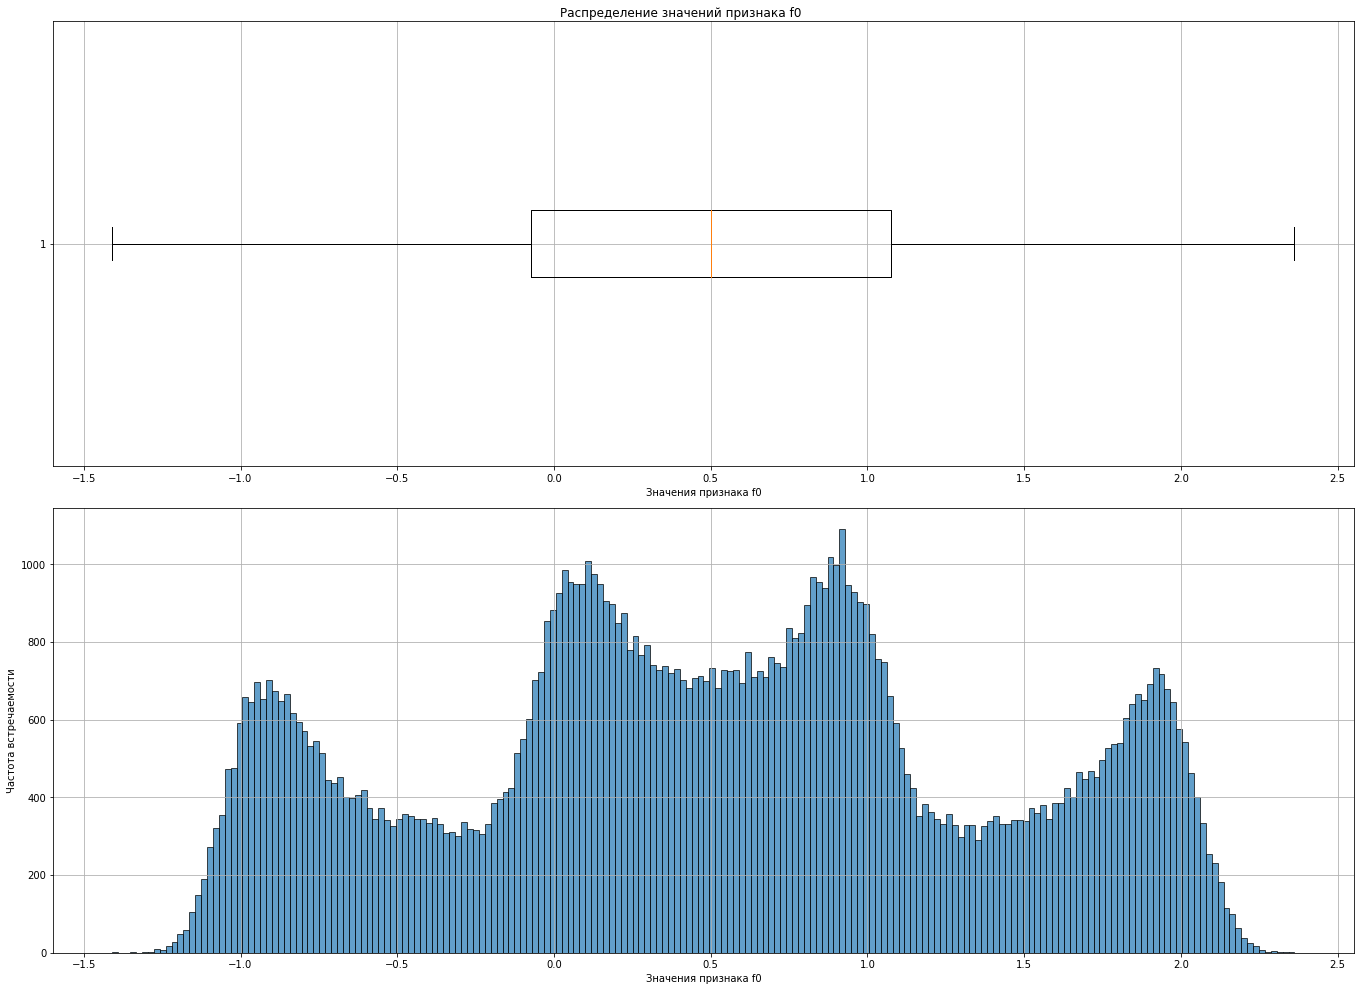

In [14]:
# Вызываем функцию describe_column_numeric с указанием признака 'f0' и датасета region_data_1
describe_column_numeric('f0', region_data_1)

Признак f1 :
count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64


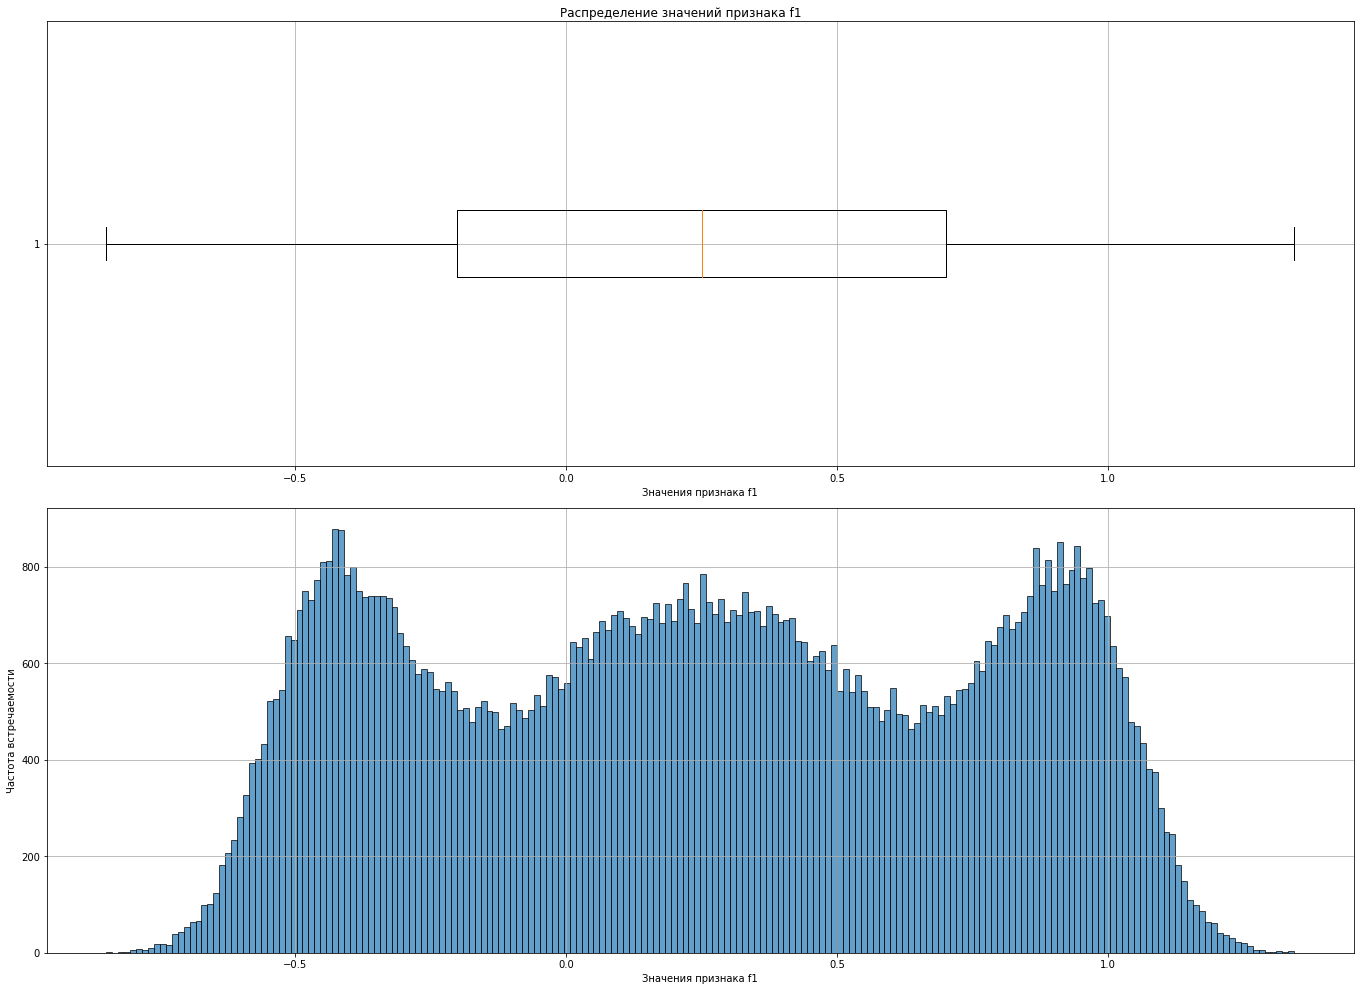

In [15]:
# Вызываем функцию describe_column_numeric с указанием признака 'f1' и датасета region_data_1
describe_column_numeric('f1', region_data_1)

Признак f2 :
count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64


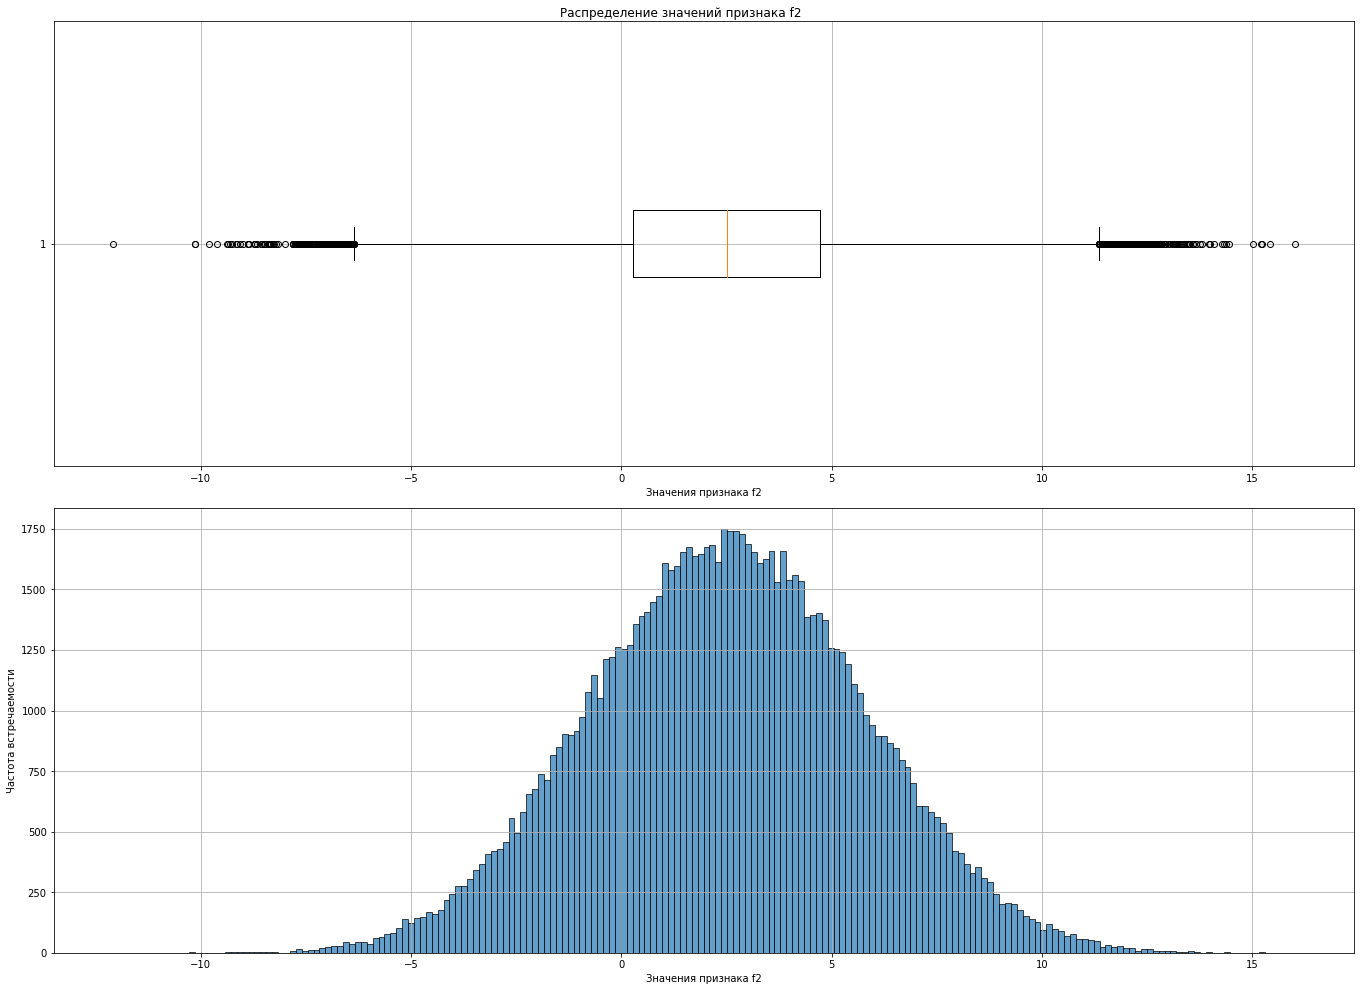

In [16]:
# Вызываем функцию describe_column_numeric с указанием признака 'f2' и датасета region_data_1
describe_column_numeric('f2', region_data_1)

По региону №1 в отношении распределения признаков f0, f1, f2 отмечаем следующее:
- значения признака f2 распределены нормально, в диапазоне (-12, 16) со средним в районе 2.5
- распределение значений признаков f0 и f1 не является нормальным, практически является симметричным относительно медианного значения. f0 лежит в диапазоне (-1.4, 2.4), f1 - (-0.8, 1.3)

**Регион №2**

Признак f0 :
count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64


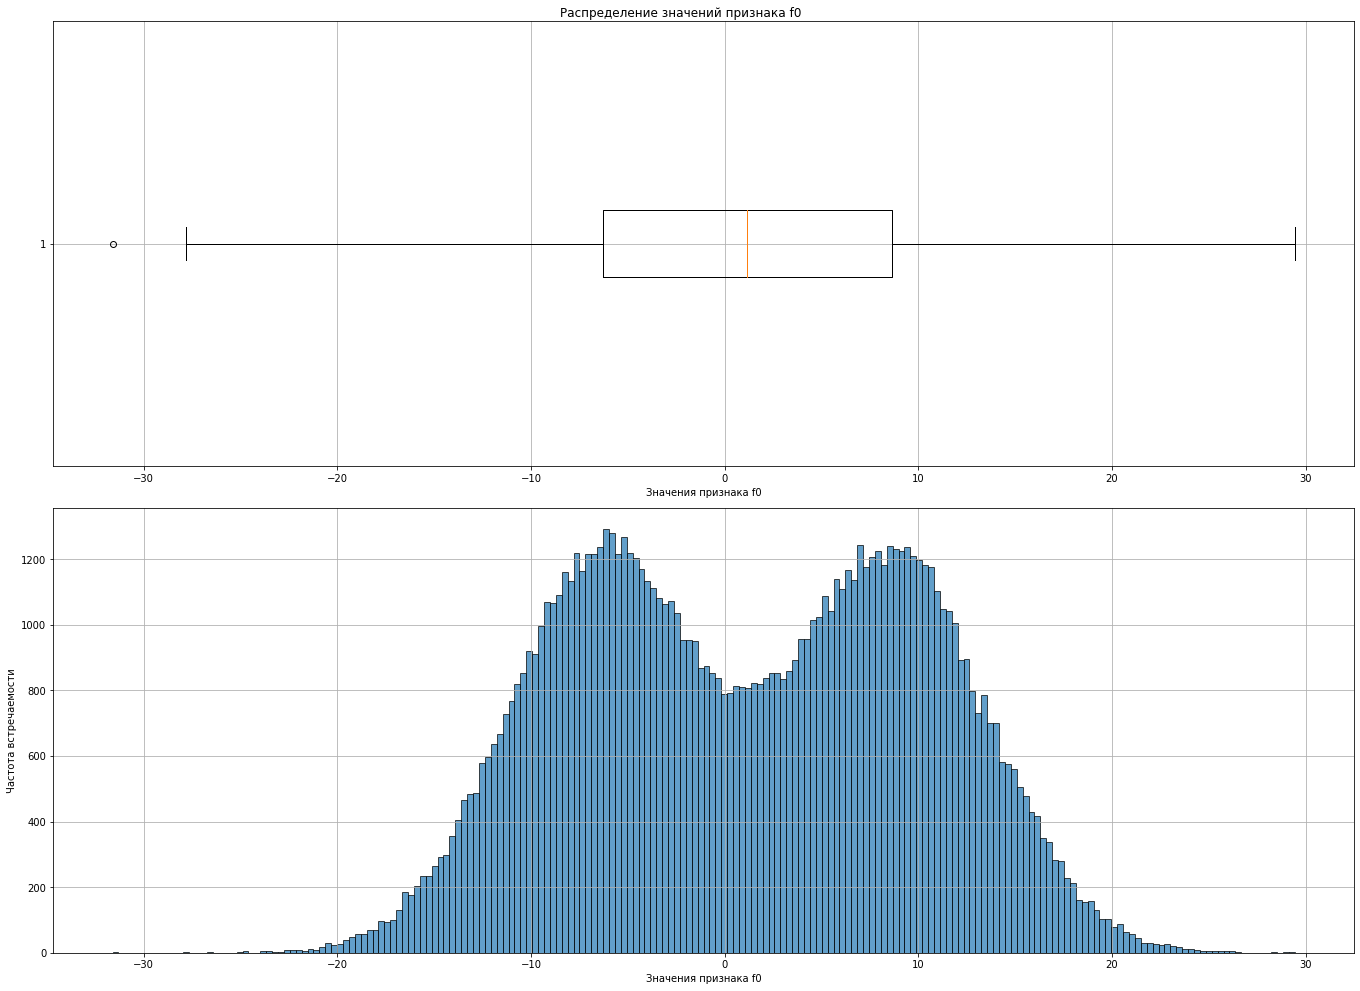

In [17]:
# Вызываем функцию describe_column_numeric с указанием признака 'f0' и датасета region_data_2
describe_column_numeric('f0', region_data_2)

Признак f1 :
count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64


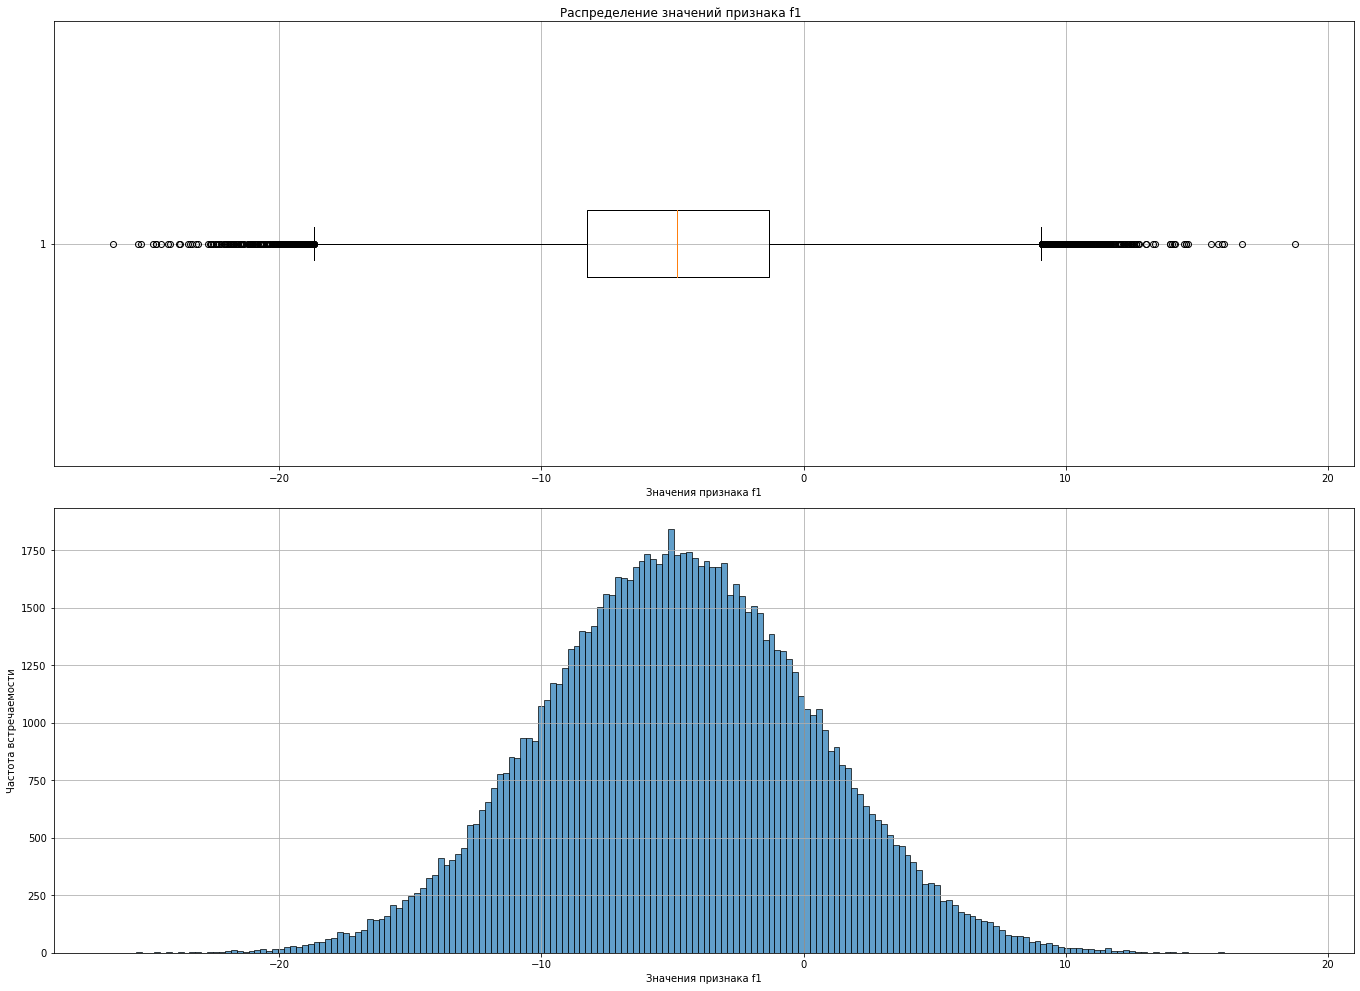

In [18]:
# Вызываем функцию describe_column_numeric с указанием признака 'f1' и датасета region_data_2
describe_column_numeric('f1', region_data_2)

Признак f2 :
count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64


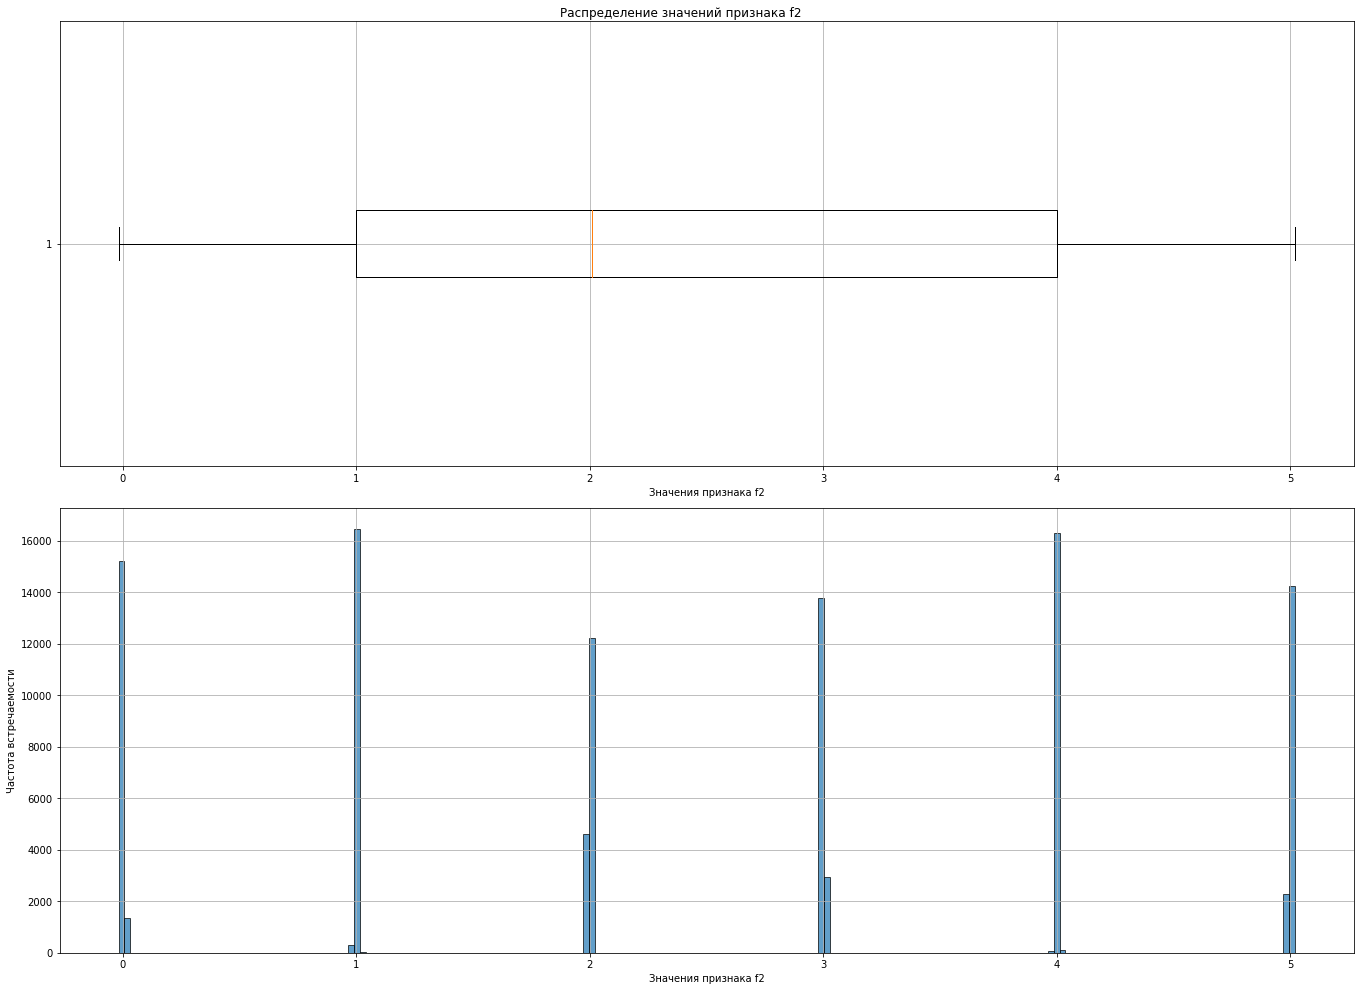

In [19]:
# Вызываем функцию describe_column_numeric с указанием признака 'f2' и датасета region_data_2
describe_column_numeric('f2', region_data_2)

По региону №2 в отношении распределения признаков f0, f1, f2 отмечаем следующее:
- значения признака f1 распределены нормально, в диапазоне (-26, 19) со средним в районе -4.8
- распределение значений признака f0 не является нормальным, практически является симметричным относительно медианного значения 1.1, заданы в диапазоне (-32, 29)
- Исходя из фактических данных, признак f2 имеет значения в пределах от -0.018144 до 5.019721. При этом 25% значений находятся в диапазоне от 1.000021 до 2.011479, а 75% значений находятся в диапазоне от 2.011479 до 3.999904. Основываясь на этой информации, можно сделать вывод, что значения признака f2 находятся в пределах 0.05 от целых чисел: 0, 1, 2, 3, 4, 5. Следовательно, целесообразно рассмотреть возможность приведения данного признака к целочисленному формату, фактически категориальному.

In [21]:
# Округляем значения признака 'f2' и преобразуем их в целые числа
region_data_2['f3'] = region_data_2['f2'].round().astype(int)

# Вызываем функцию describe_column_category для анализа категориального признака 'f3' в датасете region_data_2
describe_column_category('f3', region_data_2)

Признак f3 :

Уникальные значения (процент):
2    16.9%
1    16.8%
3    16.8%
0    16.6%
5    16.5%
4    16.5%
Name: f3, dtype: object


В ходе дальнейшего обучения модели линейной регрессии будет более детально исследовано возможное применение производного признака f3.

**Регион №3**

Признак f0 :
count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64


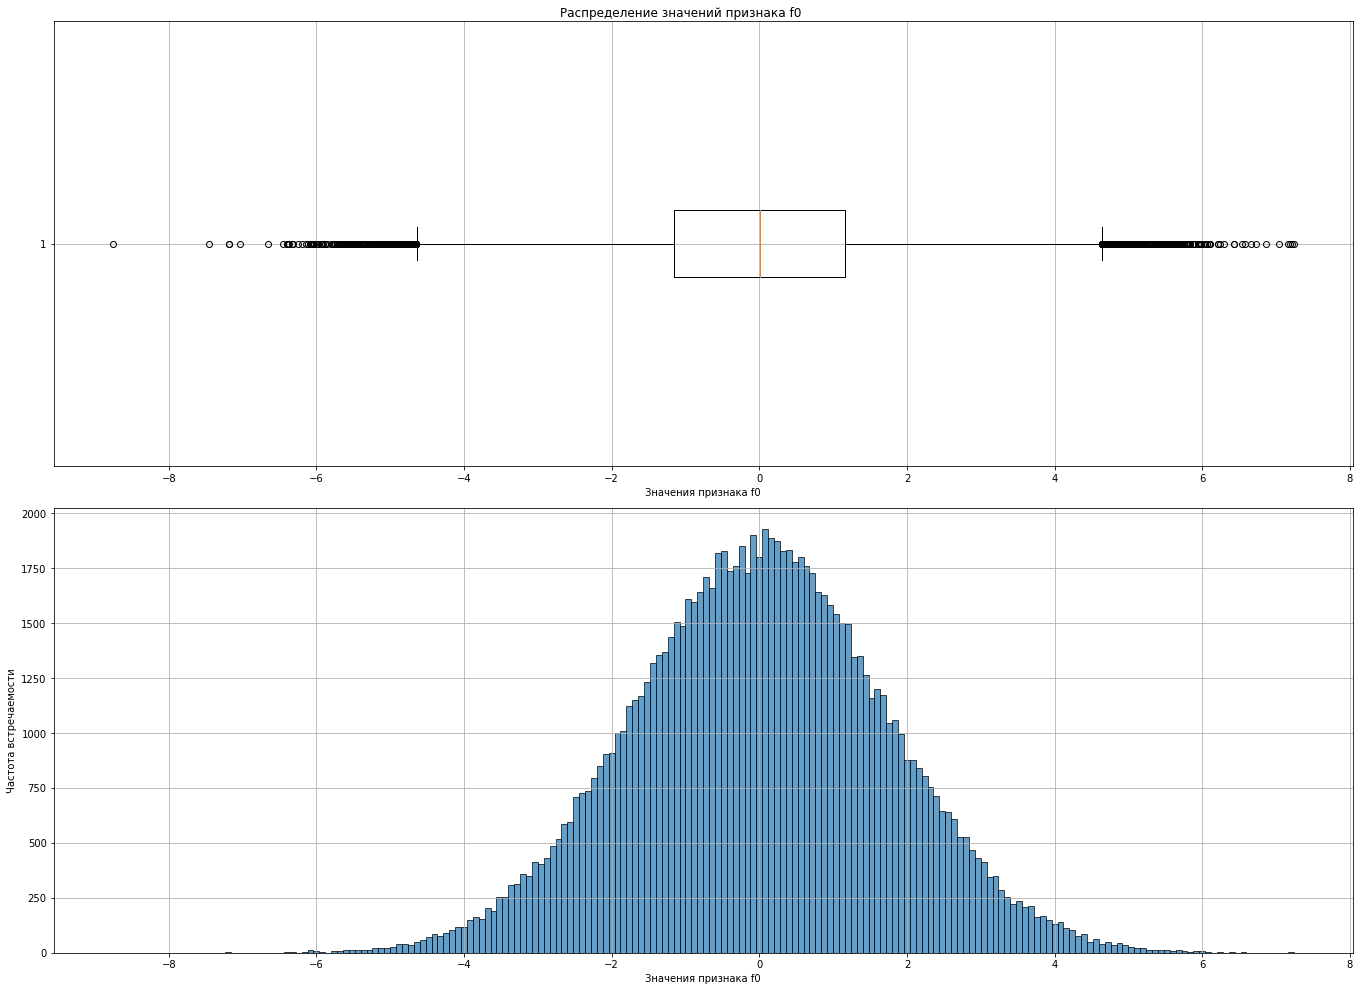

In [22]:
# Вызываем функцию describe_column_numeric для анализа числового признака 'f0' в датасете region_data_3
describe_column_numeric('f0', region_data_3)

Признак f1 :
count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64


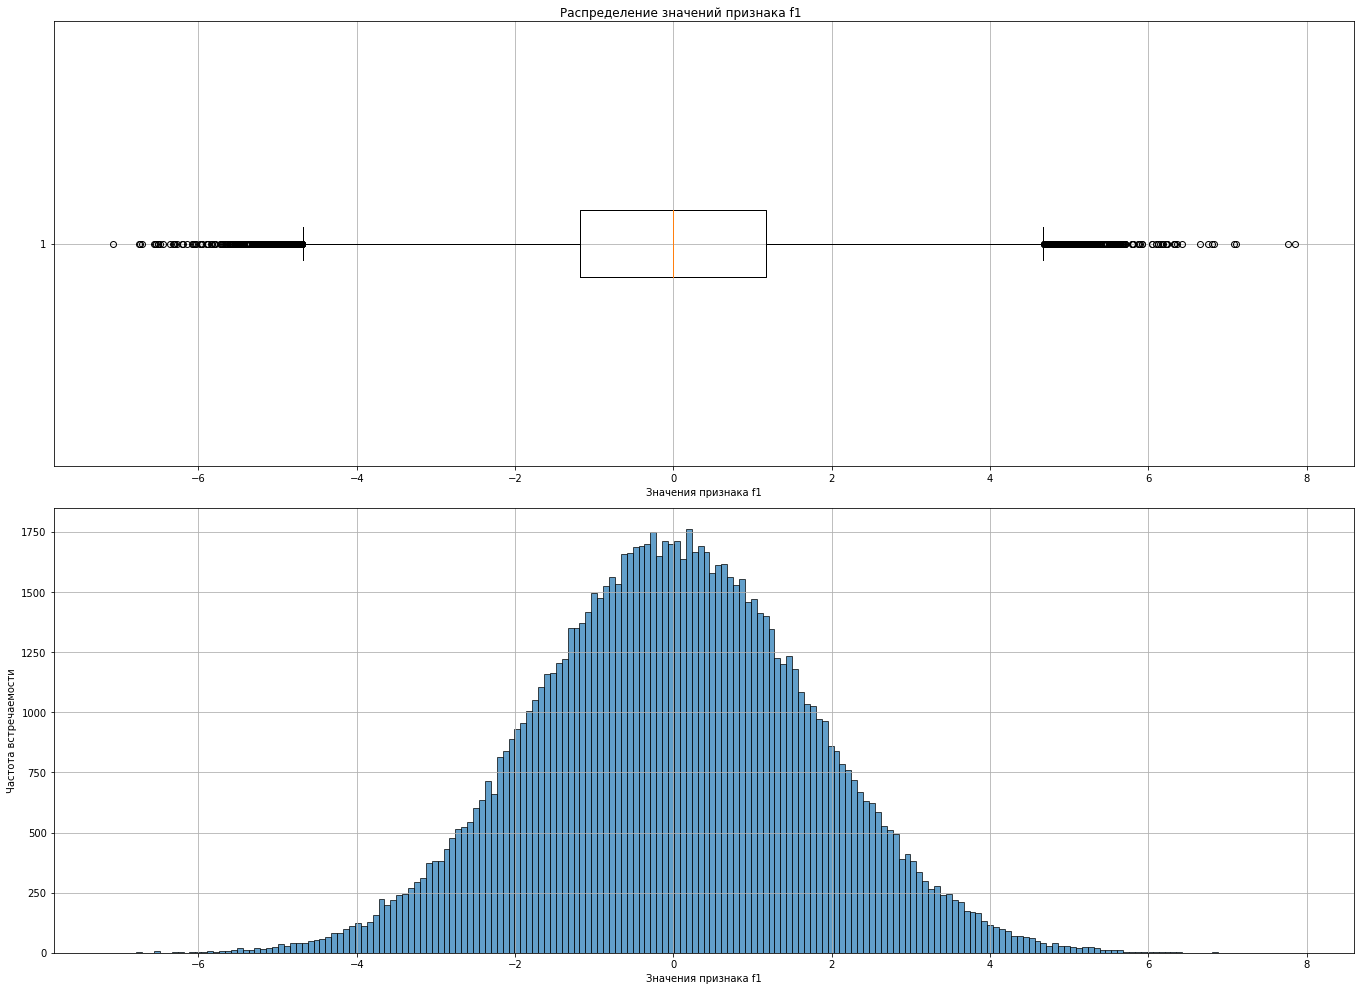

In [23]:
# Вызываем функцию describe_column_numeric для анализа числового признака 'f1' в датасете region_data_3
describe_column_numeric('f1', region_data_3)

Признак f2 :
count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64


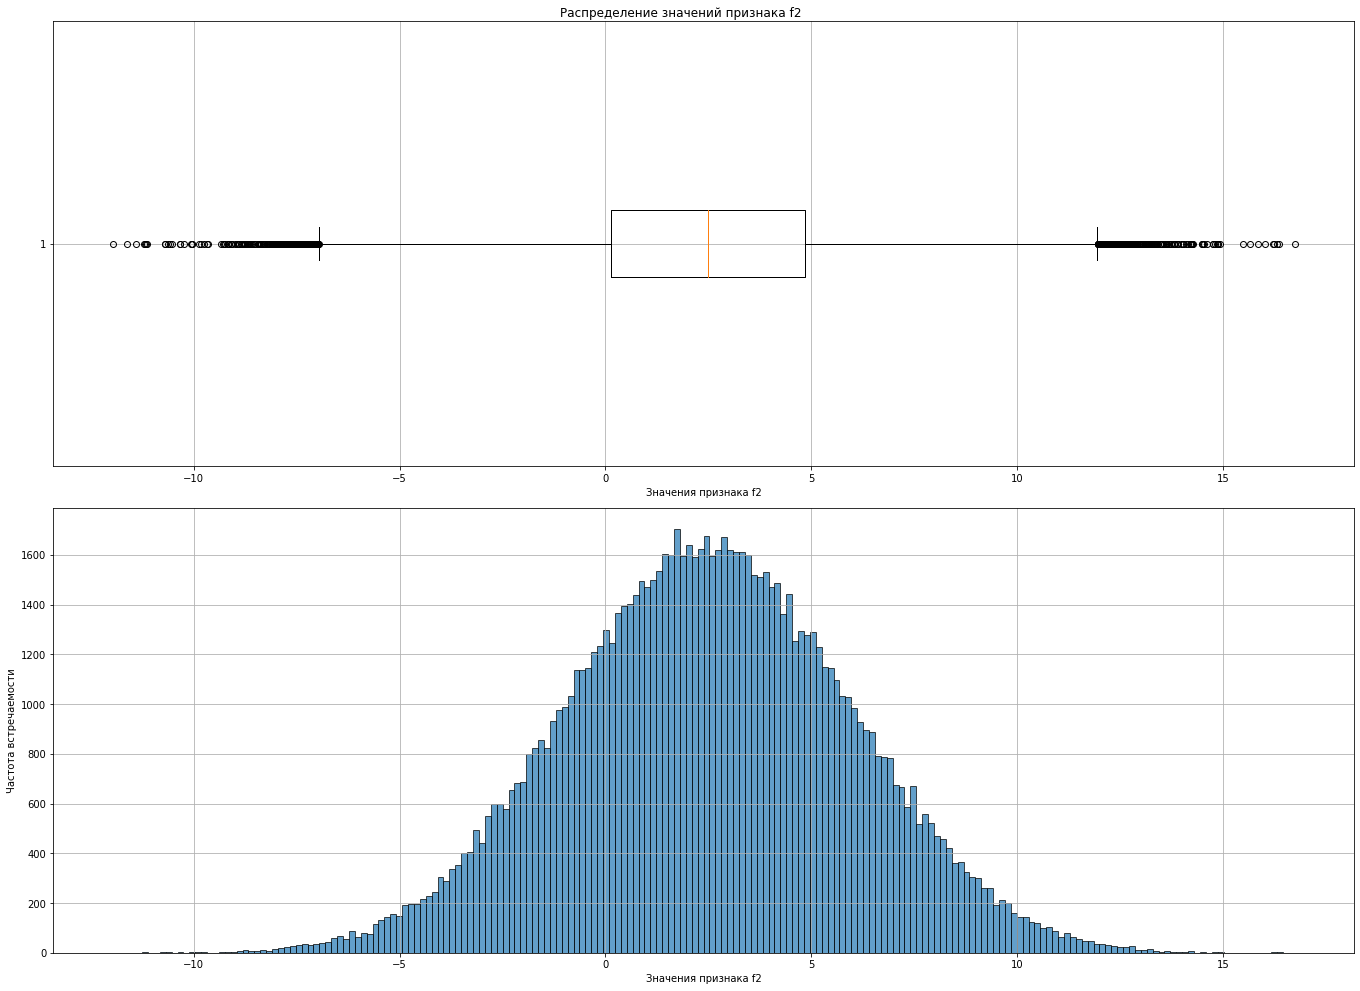

In [24]:
# Вызываем функцию describe_column_numeric для анализа числового признака 'f2' в датасете region_data_3
describe_column_numeric('f2', region_data_3)

По региону №3 в отношении распределения признаков f0, f1, f2 отмечаем следующее:
- значения всех признаков распределены нормально, каждый в своем диапазоне: (-9, 7), (-7, 8), (-12, 17) соответственно

Обратим внимание, что распределения признаков в разных регионах значительно отличаются: они имеют различный характер и охват значений. Учитывая, что нет дополнительной информации о связях между признаками в разных регионах, каждый набор признаков следует анализировать независимо для каждого региона. Таким образом, модели обучения будут разрабатываться отдельно для каждого региона, учитывая его уникальные особенности.

**Проверка корреляций**

Проведем оценку корреляций между обучающими и целевым признаком (`product`), а также оценим наличие возможной мультиколлинеарности между обучающими признаками.

In [25]:
# функция печати диагональной тепловой карты со значениями коэффициентов корреляции
# df_corr - dataframe с коэффициентами корреляции
def print_corr_heatmap(df_corr):
    
    # Преобразование значений коэффициентов корреляции в абсолютные значения и замена диагональных элементов на 0
    df_corr = np.abs(df_corr).replace(1, 0)
    
    # Создание маски для скрытия верхнего треугольника тепловой карты
    mask = np.zeros_like(df_corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Создание фигуры и осей для тепловой карты
    fig, ax = plt.subplots(figsize=(19, 15))
    
    # Построение тепловой карты
    heatmap = ax.imshow(df_corr, cmap='coolwarm', interpolation='nearest')
    
    # Добавление цветовой шкалы
    cbar = plt.colorbar(heatmap)
    cbar.set_label('Correlation Coefficient')

    # Установка делений и подписей на осях
    ax.set_xticks(np.arange(df_corr.shape[1]))
    ax.set_yticks(np.arange(df_corr.shape[0]))
    ax.set_xticklabels(df_corr.columns, rotation=45, ha='right')
    ax.set_yticklabels(df_corr.columns)

    # Добавление аннотаций
    for i in range(df_corr.shape[0]):
        for j in range(df_corr.shape[1]):
            ax.text(j, i, format(df_corr.iloc[i, j], '.2f'),
                    ha='center', va='center', color='black')
    
    # Установка заголовка и подписей осей
    plt.title('Матрица модулей коэффициентов корреляции', fontsize=19)
    plt.xlabel('Признак', fontsize=19)
    plt.ylabel('Признак', fontsize=19)
    
    # Отображение тепловой карты
    plt.show()

In [26]:
# функция печати таблицы коэффициентов корреляции и тепловой карты с модулями коэффициентов
# df_corr - dataframe с коэффициентами корреляции
def print_corr_data(df_region, corr_matrix=True):
    
    # Вывод разделителя для таблицы корреляции
    print('{0}  Таблица корреляции  {0}'.format('*' * 50))
    # Вычисление матрицы корреляции
    df_corr = df_region.corr()
    # Вывод таблицы корреляции
    display(df_corr)
    # Печать диагональной тепловой карты коэффициентов корреляции
    print_corr_heatmap(df_corr)
    # Если нужно, построение графиков взаимной зависимости признаков
    if corr_matrix:
        # Создание сетки графиков
        fig, axes = plt.subplots(nrows=len(df_region.columns), ncols=len(df_region.columns), figsize=(19, 19))
        fig.subplots_adjust(hspace=0.3, wspace=0.3)
        # Построение гистограмм для диагональных элементов
        for i, column_i in enumerate(df_region.columns):
            for j, column_j in enumerate(df_region.columns):
                if i == j:
                    axes[i, j].hist(df_region[column_i], bins=20, alpha=0.7)
                    axes[i, j].set_xlabel(column_i)
                    axes[i, j].set_ylabel('Frequency')
                else:
                    # Построение диаграммы рассеяния для недиагональных элементов
                    axes[i, j].scatter(df_region[column_i], df_region[column_j], alpha=0.7)
                    axes[i, j].set_xlabel(column_i)
                    axes[i, j].set_ylabel(column_j)
        # Отображение графиков
        plt.show()

**Регион №1**

**************************************************  Таблица корреляции  **************************************************


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


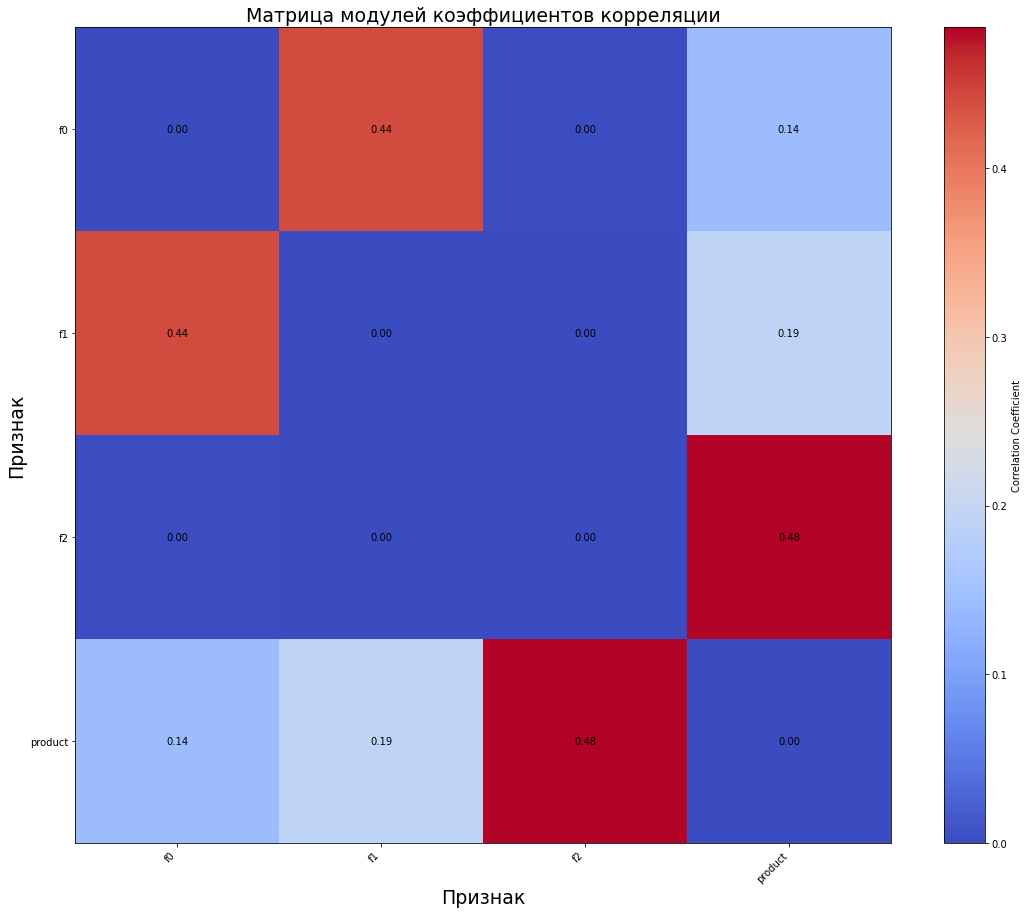

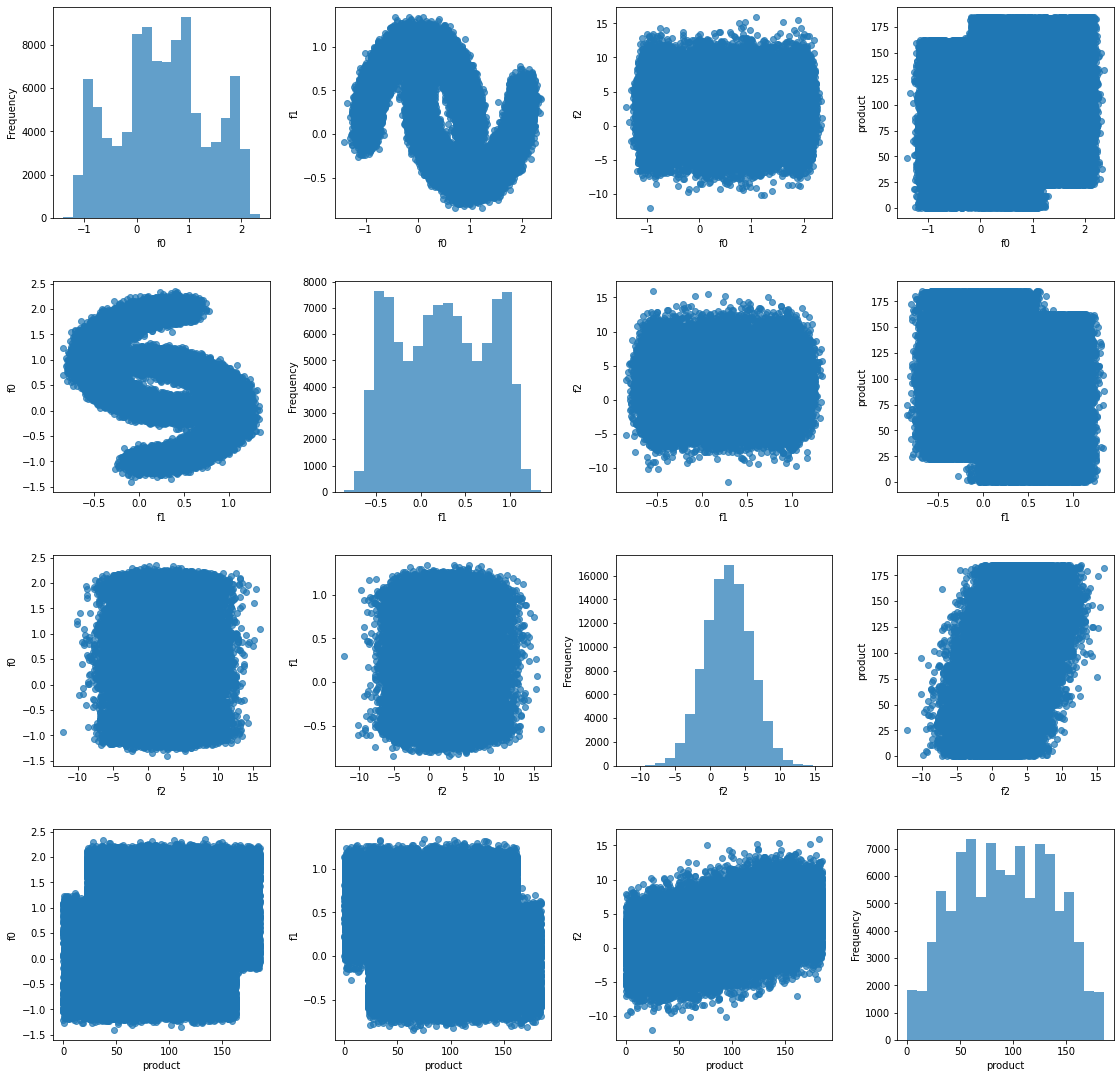

In [27]:
# Вызываем функцию print_corr_data для анализа корреляции признаков в датасете region_data_1
print_corr_data(region_data_1)

На основании данных о корреляции признаков, можно сделать следующие выводы:

Признаки "f0" и "product" имеют положительную корреляцию с коэффициентом 0.143536. Это указывает на некоторую слабую положительную зависимость между этими признаками. Однако, коэффициент корреляции не является очень высоким, поэтому связь между ними не является сильной.

Признаки "f1" и "product" имеют отрицательную корреляцию с коэффициентом -0.192356. Это указывает на некоторую слабую отрицательную зависимость между этими признаками. Опять же, коэффициент корреляции не является очень высоким, поэтому связь между ними также не является сильной.

Признаки "f2" и "product" имеют наиболее значимую корреляцию с коэффициентом 0.483663. Это указывает на существенную положительную зависимость между этими признаками. Коэффициент корреляции достаточно высокий, что указывает на наличие сильной линейной связи между признаками.

Исходя из этого, можно сделать вывод, что признак "f2" имеет наибольшую связь с целевой переменной "product" в сравнении с другими признаками. Это может быть полезной информацией при построении модели и выборе наиболее значимых признаков для прогнозирования "product".

**Регион №2**

**************************************************  Таблица корреляции  **************************************************


,f0,f1,f2,product,f3
f0,1.000000,0.182287,-0.001777,-0.030491,-0.001774
f1,0.182287,1.000000,-0.002595,-0.010155,-0.002571
f2,-0.001777,-0.002595,1.000000,0.999397,0.999996
product,-0.030491,-0.010155,0.999397,1.000000,0.999401
f3,-0.001774,-0.002571,0.999996,0.999401,1.000000


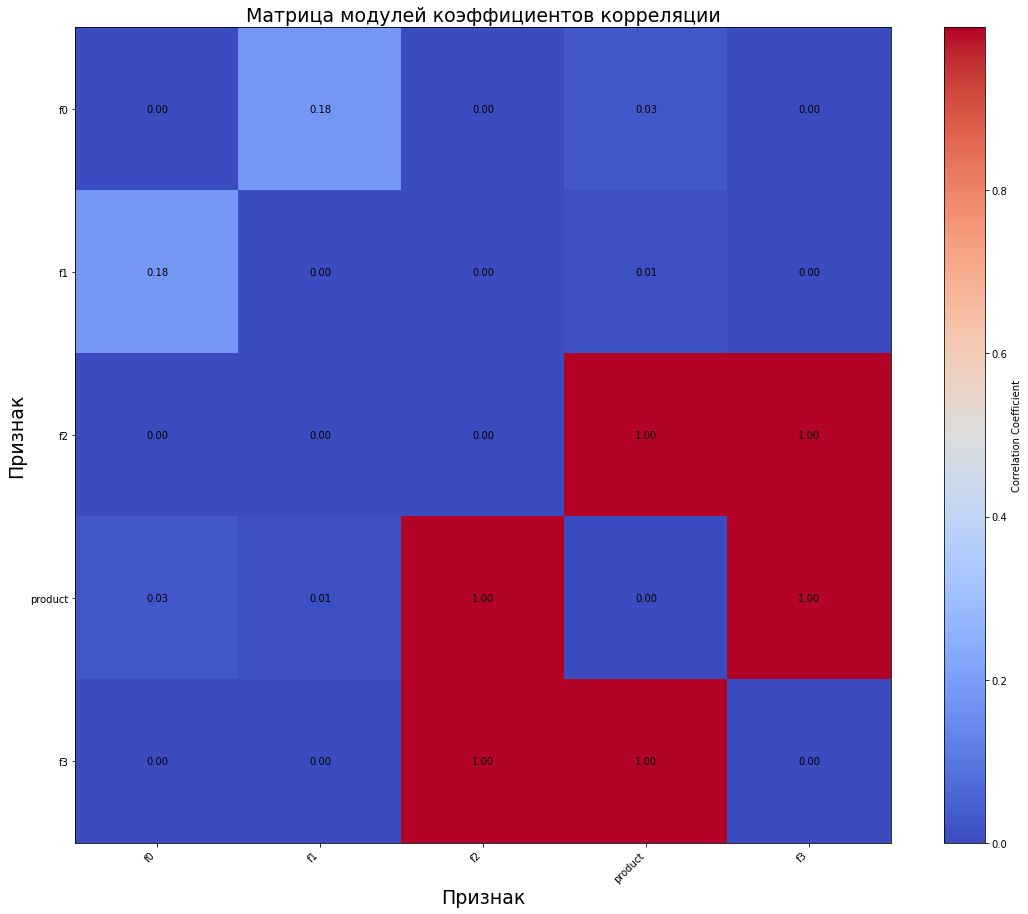

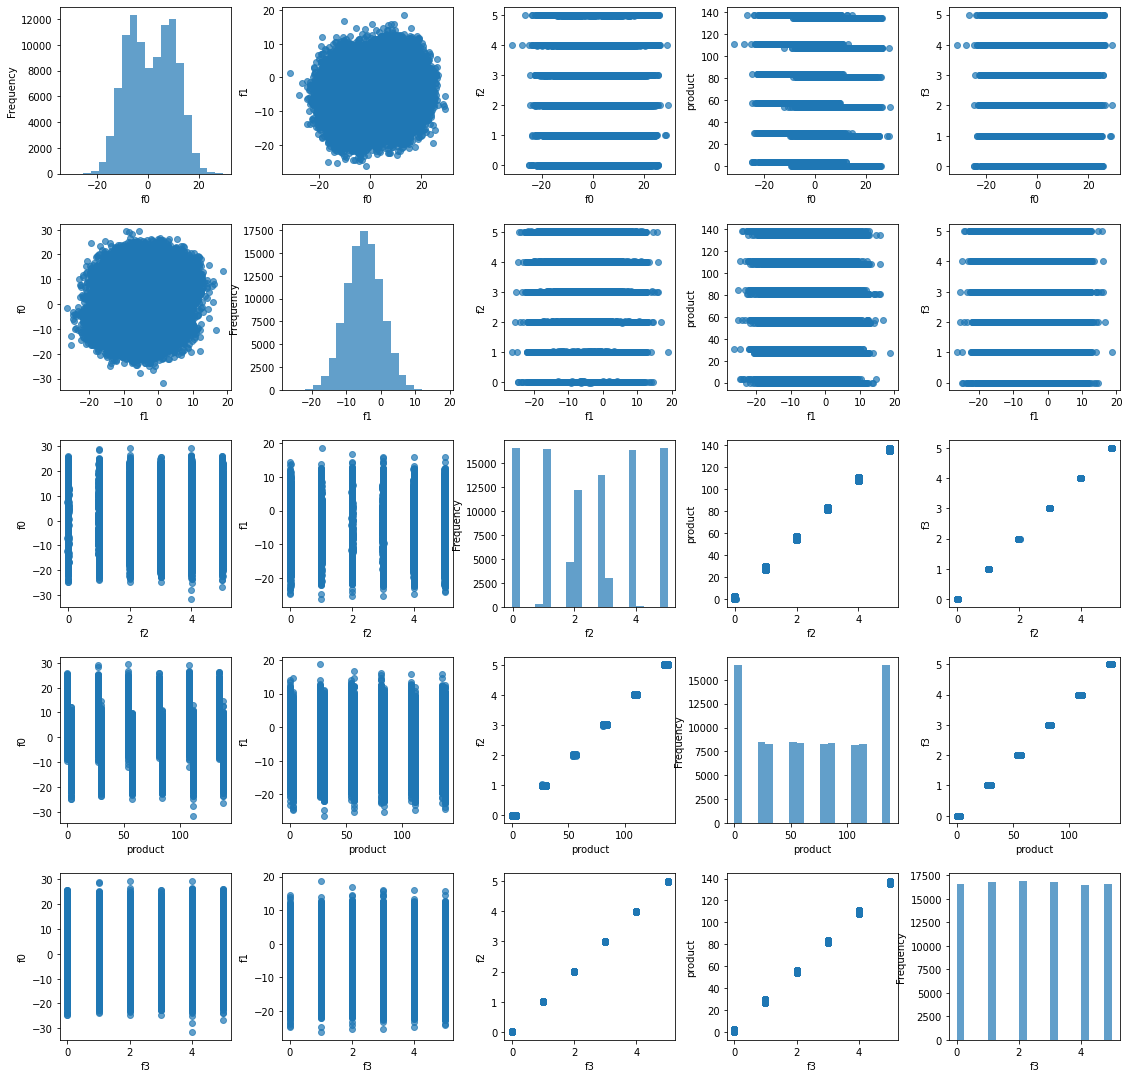

In [28]:
# Вызываем функцию print_corr_data для анализа корреляции признаков в датасете region_data_2
print_corr_data(region_data_2)

На основании данных о корреляции признаков, можно сделать следующие выводы:

Признаки "f0", "f1" и "product" имеют слабую корреляцию между собой. Коэффициенты корреляции между ними близки к нулю, что указывает на отсутствие сильной линейной зависимости между этими признаками.

Признаки "f2" и "product" имеют очень высокую положительную корреляцию с коэффициентом 0.999397. Это указывает на сильную линейную зависимость между этими признаками. Коэффициент корреляции близок к 1, что говорит о том, что значения этих признаков линейно связаны друг с другом.

Признак "f3" имеет очень высокую положительную корреляцию с признаками "f2" и "product". Коэффициенты корреляции между ними близки к 1, что указывает на сильную линейную связь. Это говорит о том, что значения признака "f3" тесно связаны с значениями признаков "f2" и "product".

Исходя из этого, можно сделать вывод, что признаки "f2" и "f3" имеют сильную линейную связь между собой и с целевой переменной "product". Это может быть важной информацией при построении модели и выборе наиболее значимых признаков для прогнозирования "product".

**Регион №3**

**************************************************  Таблица корреляции  **************************************************


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


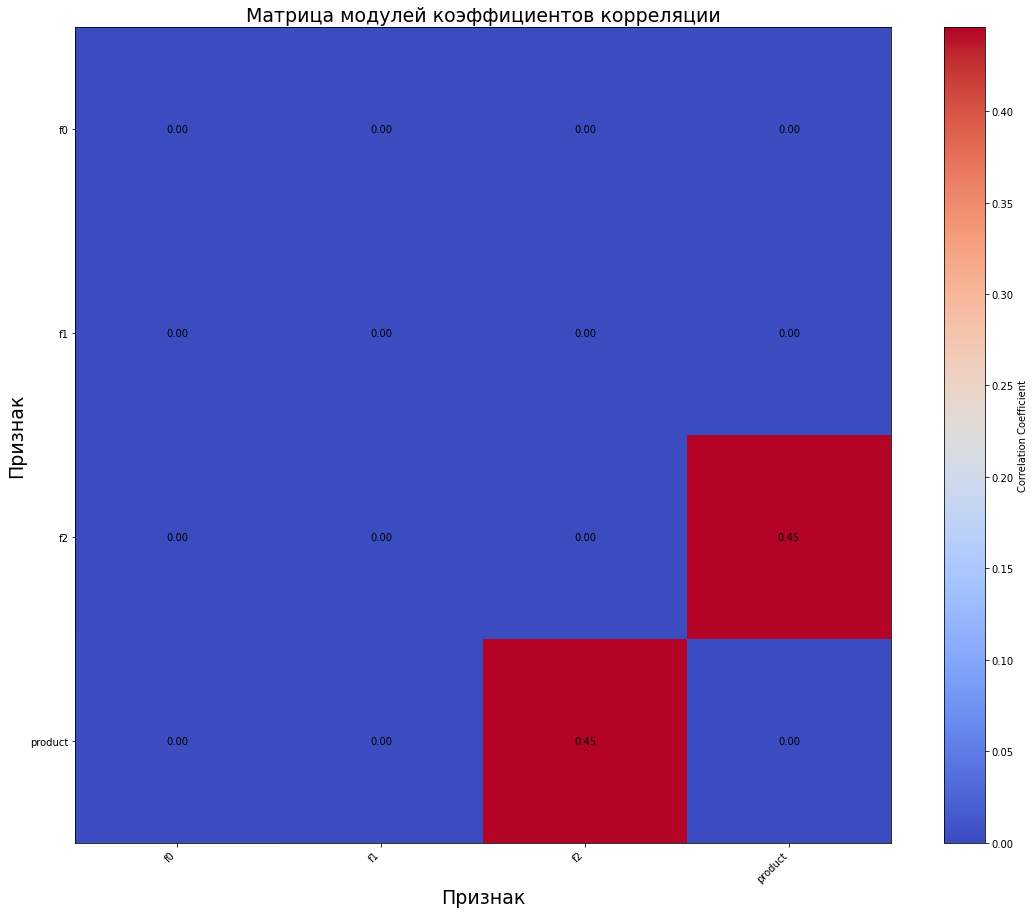

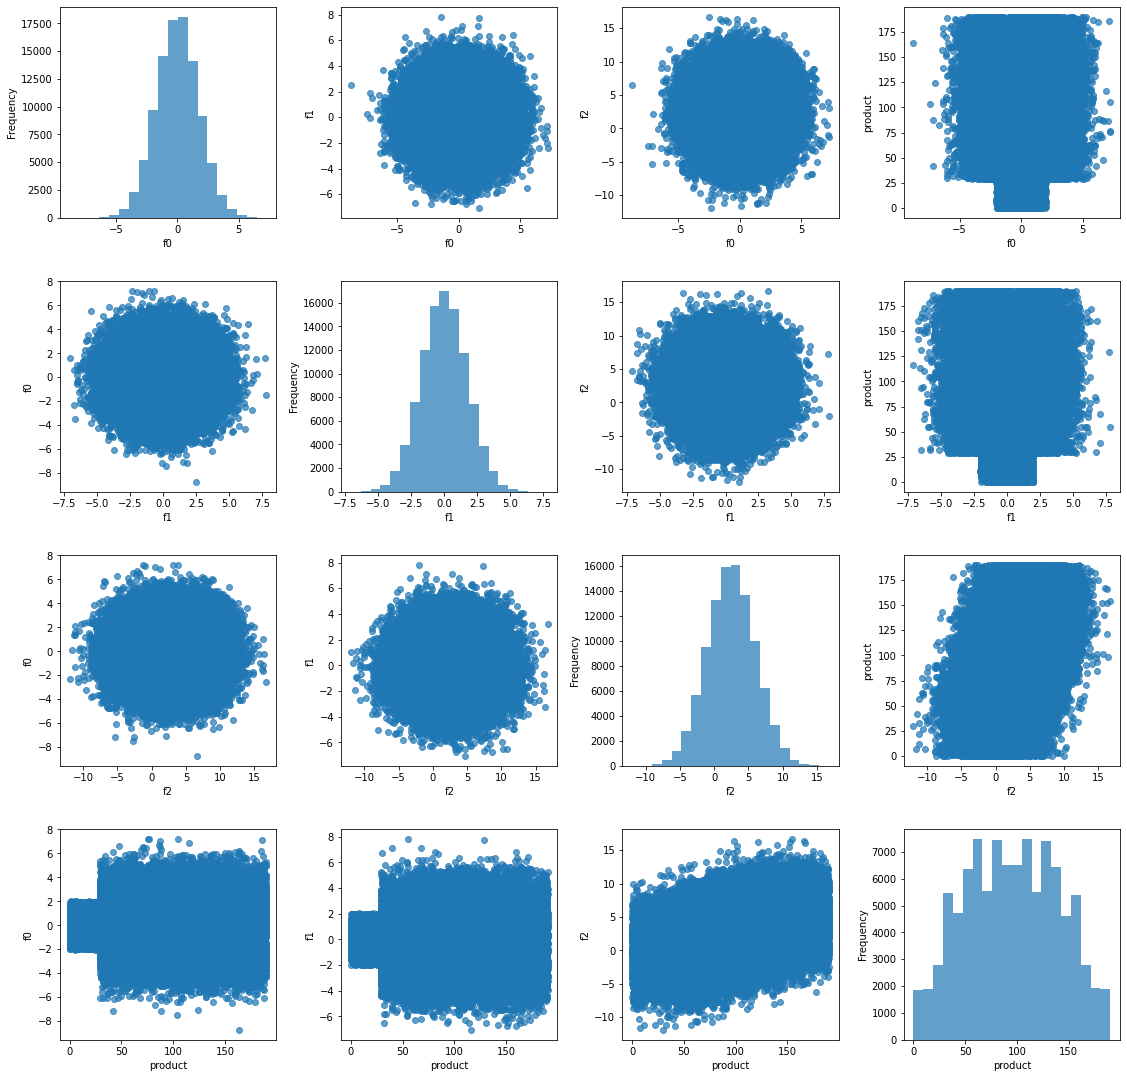

In [29]:
# Вызываем функцию print_corr_data для анализа корреляции признаков в датасете region_data_3
print_corr_data(region_data_3)

На основании данных о корреляции признаков, можно сделать следующие выводы:

Признаки "f0" и "f1" имеют очень слабую корреляцию между собой. Коэффициент корреляции близок к нулю, что указывает на отсутствие линейной зависимости между этими признаками.

Признаки "f0" и "product" также имеют очень слабую корреляцию. Коэффициент корреляции близок к нулю, что указывает на отсутствие линейной зависимости между этими признаками.

Признаки "f1" и "product" также имеют очень слабую корреляцию. Коэффициент корреляции близок к нулю, что указывает на отсутствие линейной зависимости между этими признаками.

Признак "f2" имеет некоторую положительную корреляцию с целевой переменной "product". Коэффициент корреляции равен 0.445871, что указывает на слабую линейную связь между этими признаками.

Исходя из этого, можно сделать вывод, что признаки "f0" и "f1" не имеют значительной линейной связи с целевой переменной "product". Однако, признак "f2" имеет некоторую положительную корреляцию с "product", что может указывать на наличие некоторой зависимости между ними.

# Выводы

В процессе предварительной обработки данных были выполнены следующие шаги: произведена загрузка данных и проверка их соответствия метаописанию, определены обучающие и целевой признаки, проведена оценка распределения значений обучающих признаков по регионам, а также оценка корреляций между признаками. Было установлено, что в исходных данных отсутствуют мультиколлинеарные признаки, а также обнаружена высокая корреляция между целевым признаком и одним из обучающих признаков в регионе №2. Однако, ввиду недостатка информации о значениях признаков, решено не считать это источником возможной утечки данных. При подготовке к этапу обучения моделей учтены особенности распределения значений обучающих признаков по регионам, и предлагается рассмотреть способы стандартизации обучающих признаков на этапе обучения моделей, учитывая различия в типах и области определения признаков. Кроме того, модели обучения будут рассматриваться независимо друг от друга для каждого региона.

## Обучение и проверка модели

**Разбиение данных на обучающую и тестовую выборки**

Определим обучающие и целевой признаки

In [30]:
# Создаем списки 'features' и 'target' для определения признаков и целевой переменной
features = ['f0', 'f1', 'f2']
target = ['product']

In [31]:
# функция разбиения данных на обучающую и валидационную выборки в соотношении 75:25
# df_source - dataframe с исходными данными

def data_split(df_source, test_size=0.25):
    # Импортируем функцию train_test_split из библиотеки scikit-learn для разделения данных на обучающую и тестовую выборки
    df_train, df_test = train_test_split(
        df_source,  # Исходный датафрейм, который нужно разделить
        test_size=test_size,  # Доля данных, которую выделяем под тестовую выборку
        random_state=random_state  # Задаем случайное состояние для воспроизводимости результатов
    )

    # Возвращаем полученные обучающую и тестовую выборки
    return df_train, df_test

In [32]:
# функция формирования совокупности наборов данных: обучающие и целевые признаки обучающего и тестового наборов данных

# features - перечень обучающих признаков
# target - перечень целевых признаков
# df_train - обучающий набор данных
# df_test - тестовый набор данных

def train_test(features, target, df_train, df_test):
    return df_train[features], df_train[target].values.ravel(), df_test[features], df_test[target]

In [33]:
# функция формирования трейн/тест выборок для региона

def def_train_test(region_data_1):
    df_train, df_test = data_split(region_data_1)

    return train_test(features, target, df_train, df_test)

**Обучение модели**

Определим функции, необходимые в процессе обучения и расчета метрик моделей.

In [34]:
# функция расчета метрики RMSE

def rmse(Y_true, Y_predicted):
    return mean_squared_error(Y_true, Y_predicted) ** 0.5

In [35]:
# функция преобразования передаваемого dataframe с обучающими признаками
# pipeline - pipeline преобразования (предобработки) обучающих признаков 
# выходной параметр - dataframe с преобразованным набором обучающих признаков 
# (фактически - исходные данные для последующего обучения модели)

def get_transformed_data(pipeline, X_train):
    X_transformed = pipeline.fit_transform(X_train)
    X_transformed = pd.DataFrame(X_transformed, index=X_train.index)
    X_transformed = X_transformed.add_prefix('Xt_')
    
    return X_transformed

In [37]:
# функция вывода общей информации о преобразованном наборе данных

def transorm_train_data(pipeline, X_train):
    # Применяем пайплайн для преобразования обучающих данных
    X_transformed = get_transformed_data(pipeline, X_train)

    # Отображаем первые 5 строк преобразованных данных
    display(X_transformed.head(5))
    
    # Проводим анализ числовых признаков в преобразованных данных
    for i in range(0, len(X_transformed.columns)):
        print('\n')
        describe_column_numeric('Xt_{0}'.format(i), X_transformed)

In [41]:
# функция печати сводной информации о параметрах модели
        
def print_scores(grid_search, params):
    # Выводим наилучшее значение метрики RMSE
    print ('Наилучшее значение метрики RMSE: %0.3f' % grid_search.best_score_)
    # Выводим наилучшие параметры модели
    print ('Наилучшие параметры:')
    best_parameters = grid_search.best_estimator_.get_params()
    
    # Для каждого параметра из словаря `params` выводим его имя и наилучшее значение
    for param_name in sorted(params.keys()):
        print ('\t%s: %r' % (param_name, best_parameters[param_name]))

In [42]:
# функция печати сводной информации о параметрах модели

def print_model_metric(Y_true, Y_predicted):
    # Выводим средний запас предсказанного сырья
    print('Средний запас предсказанного сырья:', Y_predicted.mean())
    
    # Вычисляем и выводим RMSE между реальными и предсказанными значениями
    print('RMSE:', rmse(Y_true, Y_predicted))    

In [43]:
def print_feature_importance(arr_importance, column_names):
    # Получаем абсолютные значения значимости признаков
    arr_importance = np.abs(arr_importance)
    # Вычисляем относительную значимость признаков
    rel_feature_imp = 100 * (arr_importance / max(arr_importance))
    
    # Создаем DataFrame для хранения признаков и их относительной значимости
    rel_feature_df = pd.DataFrame(
        {
            'features': list(column_names),
            'rel_importance': rel_feature_imp
        }
    )
    
    # Сортируем DataFrame по убыванию относительной значимости
    rel_feature_df = rel_feature_df.sort_values('rel_importance', ascending=False)
    
    # Создаем график
    plt.figure(figsize=(20, 6))
    plt.yticks(fontsize=15)
    
    plt.barh(
        y=rel_feature_df['features'],  # Признаки по оси Y
        width=rel_feature_df['rel_importance'],  # Относительная значимость по оси X
        color='steelblue'  # Цвет столбцов
    )
    
    plt.xlabel('Относительная значимость', fontsize=25)  # Подпись оси X
    plt.ylabel('Признаки', fontsize=25)  # Подпись оси Y
    plt.show()

In [44]:
# мера, используемая при кросс-валидации - RMSE
scoring = make_scorer(rmse, greater_is_better=False)

# рассматриваемая модель - линейная регрессия (по условиям)
model = LinearRegression()

Для каждого из регионов мы проведем последовательное обучение моделей.

В качестве базовой модели выберем линейную регрессию, которую обучим на исходном наборе признаков без их стандартизации.

Дополнительно, мы также обучим модель на стандартизированном наборе данных, применяя специфичные для каждого региона методы стандартизации, учитывая фактические распределения значений признаков. Затем мы сравним значения метрики RMSE для обеих моделей. Если метрики RMSE окажутся одинаковыми, мы выберем модель с примененной стандартизацией признаков, чтобы иметь возможность использовать ее в дальнейших моделях, включая те, которые требуют стандартизированные признаки.

**Регион №1**

Сформируем трейн и тест наборы данных с обучающими и целевыми признаками

In [45]:
# Разделяем данные на обучающую и тестовую выборки
X_train, Y_train, X_test, Y_test = def_train_test(region_data_1)

**Обучение модели на исходных признаках**

Выполним обучение модели на базовом наборе признаков

In [46]:
# Обучение модели на обучающей выборке
model.fit(X_train, Y_train)

# Получение предсказаний модели на тестовой выборке
predictions = model.predict(X_test)

# Вызов функции для вывода метрик модели
print_model_metric(Y_test, predictions)

Средний запас предсказанного сырья: 92.53930438970227
RMSE: 37.592293740401786


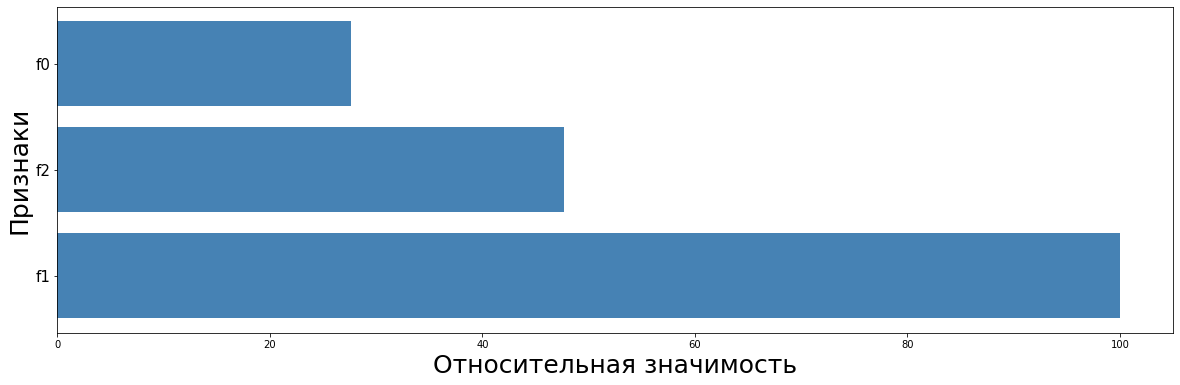

In [47]:
# Вывод важности признаков модели
print_feature_importance(model.coef_, features)

На нестандартизированных признаках наибольшую значимость в модели показал признак f1, что можно объяснить высоким коэффициентом признака в линейной регрессии. Однако, целевой признак имел наибольшую корреляцию с признаком f2. Для дальнейшего анализа мы проведем обучение модели на стандартизированных признаках и оценим относительную значимость обучающих признаков после этого.

**Обучение модели на признаках после стандартизации**

Мы проведем стандартизацию признаков в несколько шагов. Сначала, для признаков f0 и f1 мы применим метод QuantileTransformer, который приведет их к нормальному распределению. Затем, мы применим метод RobustScaler для обработки возможных выбросов в данных. Для этого, мы будем использовать GridSearchCV, чтобы подобрать оптимальные параметры отсечения. Наконец, мы применим метод StandardScaler для приведения всех стандартизированных признаков к одному масштабу и области определения.

In [48]:
# Задание шагов преобразования данных
transform_steps = [
    # Шаг 1: Квантильное преобразование для признаков f0 и f1
    ('qtl', ColumnTransformer(
        remainder='passthrough',  # Оставить остальные признаки без изменений
        transformers=[('qtl', QuantileTransformer(copy=False, output_distribution='normal'), ['f0', 'f1'])]
    )),
    
    # Шаг 2: Преобразование данных с использованием RobustScaler
    ('rob', RobustScaler(copy=False)),
    
    # Шаг 3: Стандартизация данных с использованием StandardScaler
    ('std', StandardScaler(copy=False, with_mean=True, with_std=True))
]

,Xt_0,Xt_1,Xt_2
58426,0.415452,0.533035,-0.843345
24359,-0.311046,-0.535330,-1.402458
20022,-0.092765,-0.893146,0.909563
19108,0.025604,1.167843,-2.385863
56274,0.043000,-0.661881,0.819184




Признак Xt_0 :
count    7.500000e+04
mean     2.643219e-17
std      1.000007e+00
min     -5.204808e+00
25%     -6.751591e-01
50%      7.478381e-05
75%      6.750935e-01
max      5.204783e+00
Name: Xt_0, dtype: float64


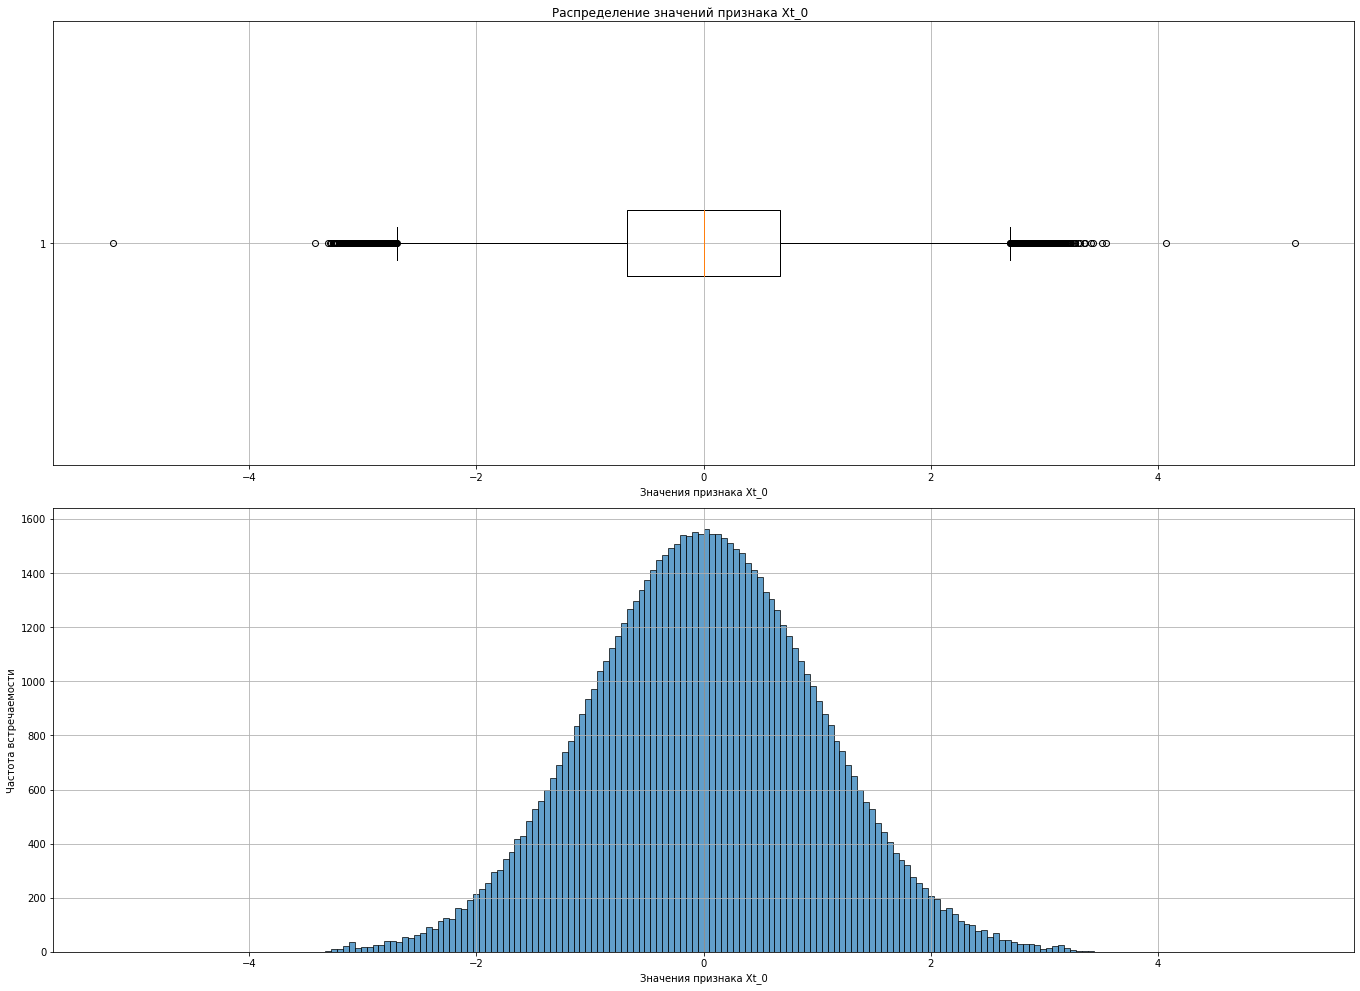



Признак Xt_1 :
count    7.500000e+04
mean     1.153448e-17
std      1.000007e+00
min     -5.205249e+00
25%     -6.755550e-01
50%      1.029825e-04
75%      6.751747e-01
max      5.205226e+00
Name: Xt_1, dtype: float64


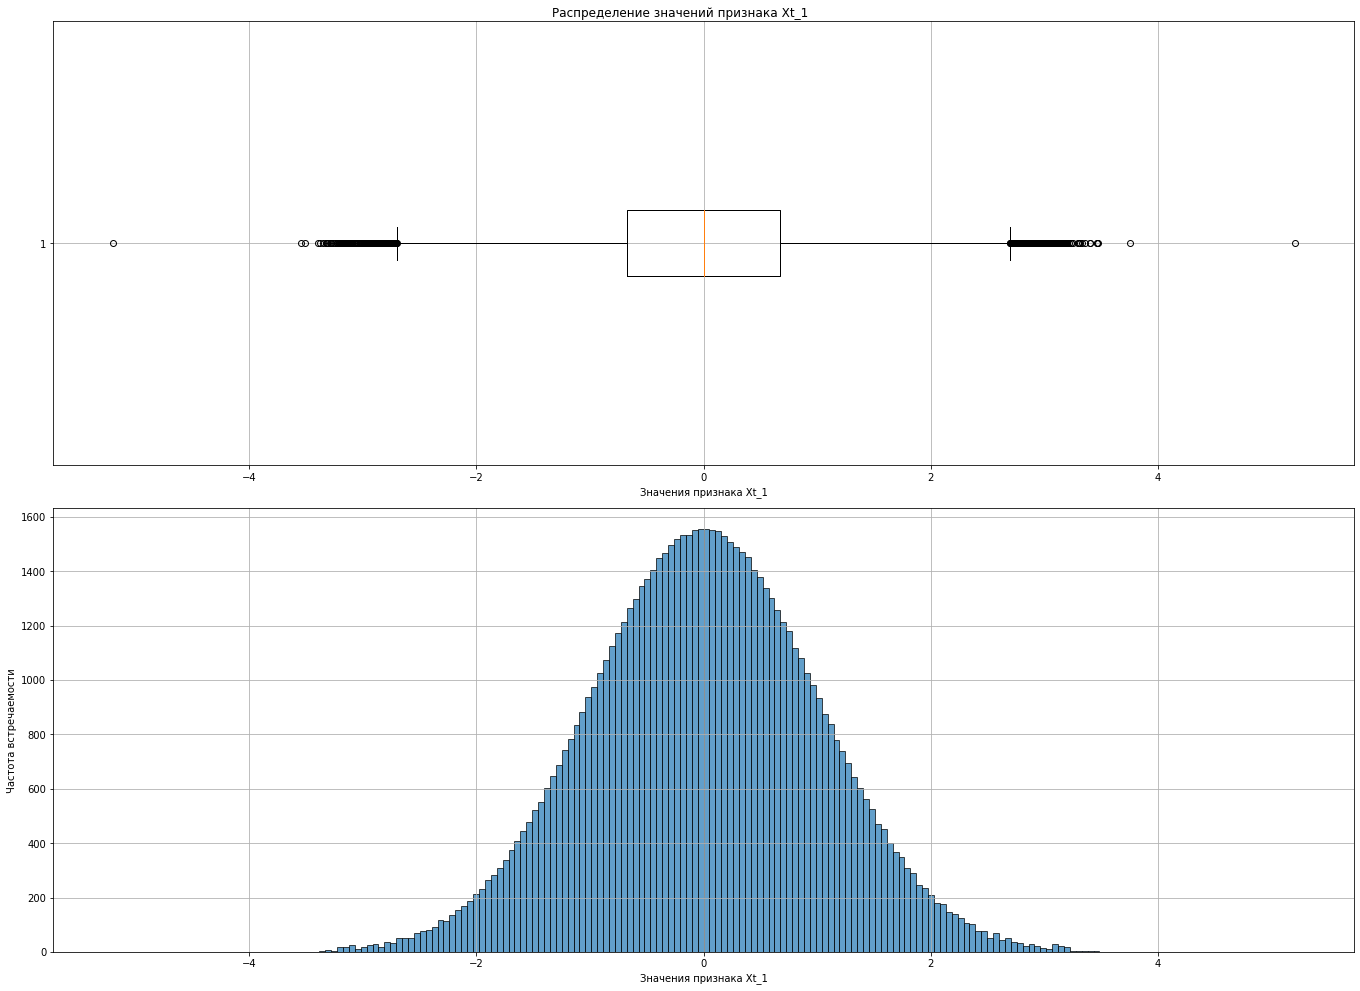



Признак Xt_2 :
count    7.500000e+04
mean    -2.124523e-17
std      1.000007e+00
min     -4.485319e+00
25%     -6.813272e-01
50%      4.397389e-03
75%      6.789682e-01
max      3.974351e+00
Name: Xt_2, dtype: float64


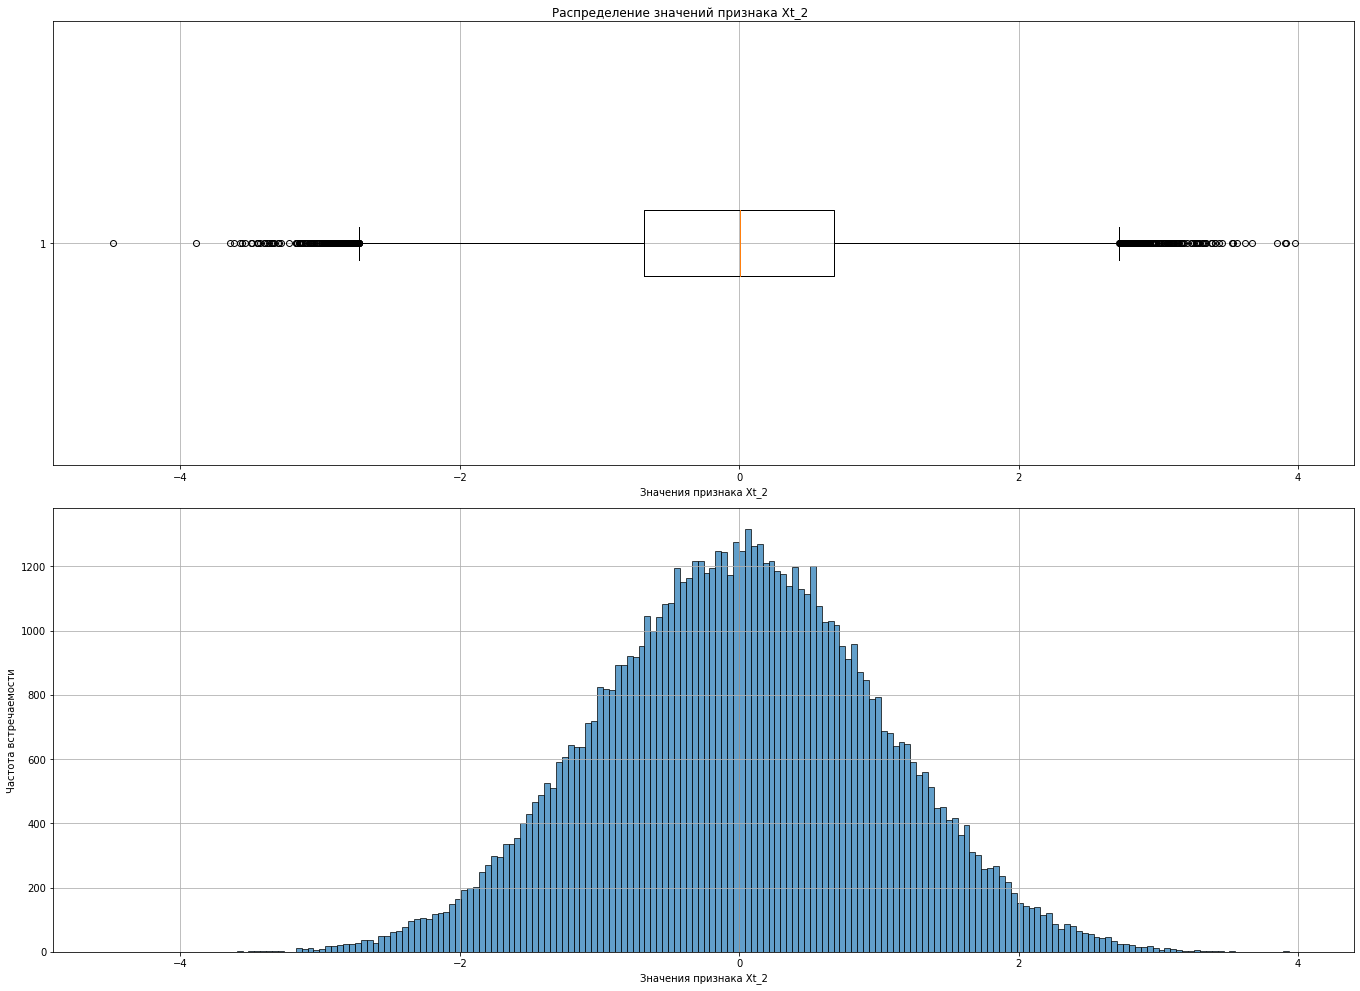

In [49]:
# Создаем пайплайн преобразования данных с заданными шагами и применяем к тренировочным данным
transorm_train_data(Pipeline(transform_steps), X_train)

После применения преобразований убедимся визуально, что все признаки стандартизированы и приведены к нормальному распределению с диапазоном значений от -4 до 4 и средним значением 0.

В качестве параметров перебора GridSearchCV используем границы отсечения RobustScaler

In [52]:
#  Определение параметров для оптимизации
params = {
    'rob__quantile_range': [(25.0, 75.0), (10.0, 90.0), (1.0, 99.0), (0, 100)],
}

# Создание объекта GridSearchCV с заданными параметрами
grid_search = GridSearchCV(
    # Пайплайн, включающий шаги преобразования данных и модель
    Pipeline(transform_steps + [('model', model)]),
    # Сетка параметров для оптимизации
    param_grid=params,
    # Количество фолдов для кросс-валидации
    cv=10,
    # Метрика оценки модели
    scoring=scoring,
)

In [53]:
# Выполняем поиск лучших параметров на тренировочных данных
grid_search.fit(X_train, Y_train)

# Выводим наилучшее значение метрики RMSE и соответствующие параметры модели
print_scores(grid_search, params)

Наилучшее значение метрики RMSE: -37.799
Наилучшие параметры:
	rob__quantile_range: (25.0, 75.0)


In [54]:
# Получаем прогнозы модели на тестовых данных
predictions_1 = grid_search.predict(X_test)

# Создаем копию целевой переменной Y_test
target_1 = Y_test.copy()

# Выводим метрику среднего запаса предсказанного сырья и RMSE для полученных прогнозов
print_model_metric(target_1, predictions_1)

Средний запас предсказанного сырья: 92.53802160855204
RMSE: 37.661245969181664


Значения метрики RMSE для рассмотренных моделей практически идентичны. Однако модель, обученная на стандартизированных признаках, предпочтительна с точки зрения возможного последующего использования и удобства.

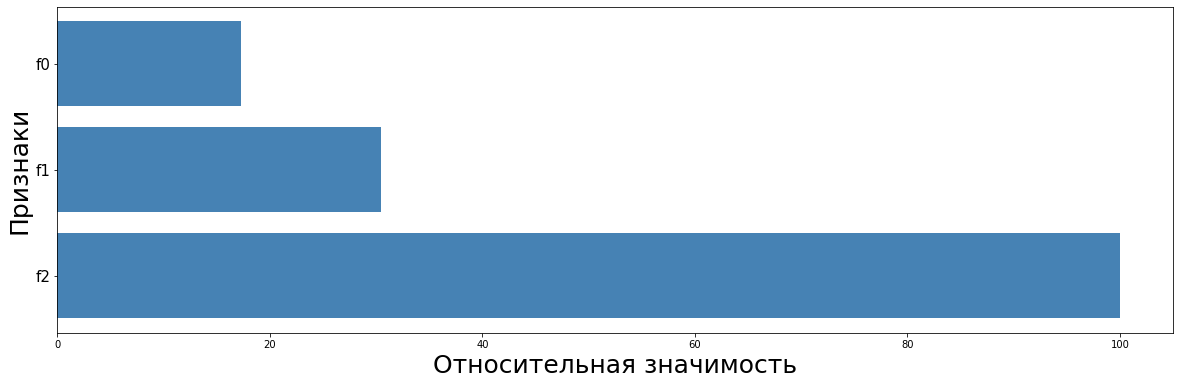

In [55]:
# Получаем коэффициенты важности признаков из лучшей модели, полученной из GridSearchCV
feature_importance = grid_search.best_estimator_.get_params()['model'].coef_

# Выводим важность признаков с их названиями
print_feature_importance(feature_importance, features)

Один из наиболее значимых признаков в модели оказался f2, что соответствует ожиданиям, так как этот признак имеет наибольшую корреляцию с целевым признаком

**Регион №2**

In [56]:
# Вызываем функцию `def_train_test` для разделения данных на тренировочную и тестовую выборки
X_train, Y_train, X_test, Y_test = def_train_test(region_data_2)

**Обучение модели на исходных признаках**

Выполним обучение модели на базовом наборе признаков

In [57]:
# Обучаем модель на тренировочных данных
model.fit(X_train, Y_train) 

# Делаем предсказания модели на тестовой выборке
predictions = model.predict(X_test) 

# Выводим метрики качества модели
print_model_metric(Y_test, predictions) 

Средний запас предсказанного сырья: 68.86641431449434
RMSE: 0.892839969728929


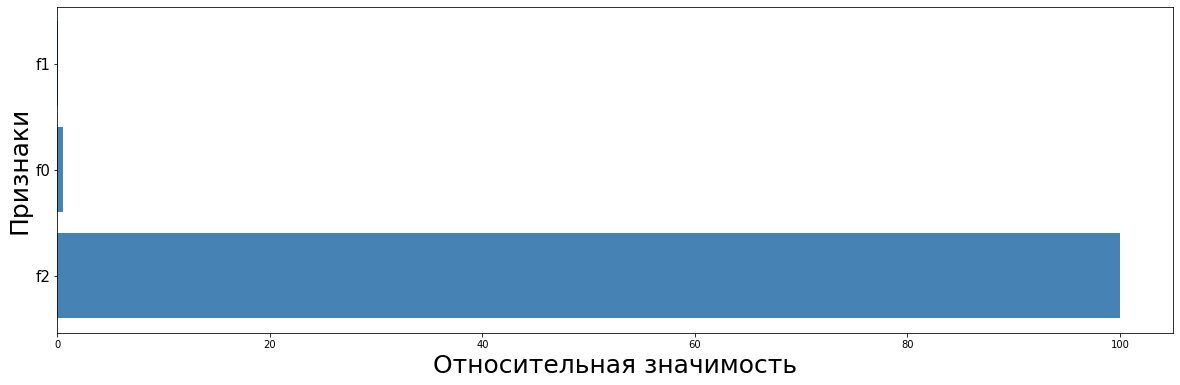

In [58]:
# Выводим важность признаков для модели
print_feature_importance(model.coef_, features)

При анализе исходных признаков стало очевидным, что наиболее важным признаком является f2, что логично, учитывая высокую корреляцию (0.999) между f2 и целевым признаком. Это говорит о том, что значения f2 сильно влияют на оценку запасов скважин в регионе №2.

**Обучение модели на признаках после стандартизации**

Для стандартизации признаков мы будем использовать следующий подход:

- Применим QuantileTransformer к признаку f0 для приведения его к нормальному распределению.
- Используем StandardScaler для стандартизации признака f1 и приведения его значений к общему масштабу.
- Вместо признака f2, мы будем использовать производный признак f3, который имеет фактически категориальные значения. Для этого применим кодировщик OrdinalEncoder() к признаку f3.

Таким образом, мы приведем все три признака к необходимым стандартам и подготовим их для использования в модели обучения.

In [59]:
# Разделяем данные на обучающий и тестовый наборы
df_train, df_test = data_split(region_data_2)

# Определяем список признаков (features) и целевую переменную (target)
X_train, Y_train, X_test, Y_test = train_test(['f0', 'f1', 'f3'], target, df_train, df_test)

In [60]:
# Определяем список шагов преобразования данных
transform_steps = [
    (
        'qtl', ColumnTransformer(
            remainder='passthrough',  # Передавать остальные признаки без изменений
            transformers=[ 
                # Применяем QuantileTransformer к признаку f0
                ('qtl', QuantileTransformer(copy=False, output_distribution='normal'), ['f0']), 
                # Применяем StandardScaler к признаку f1
                ('std', StandardScaler(copy=False, with_mean=True, with_std=True), ['f1']),
                # Применяем OrdinalEncoder к признаку f3
                ('cat', OrdinalEncoder(), ['f3'])
            ])
    ),
]

,Xt_0,Xt_1,Xt_2
58426,-1.031450,-1.051843,3.0
24359,0.604073,0.823648,3.0
20022,-0.697209,0.416081,2.0
19108,-0.597657,-0.194246,3.0
56274,0.044374,0.608735,5.0




Признак Xt_0 :
count    75000.000000
mean         0.000025
std          0.998810
min         -5.199338
25%         -0.674323
50%          0.000214
75%          0.674237
max          5.199338
Name: Xt_0, dtype: float64


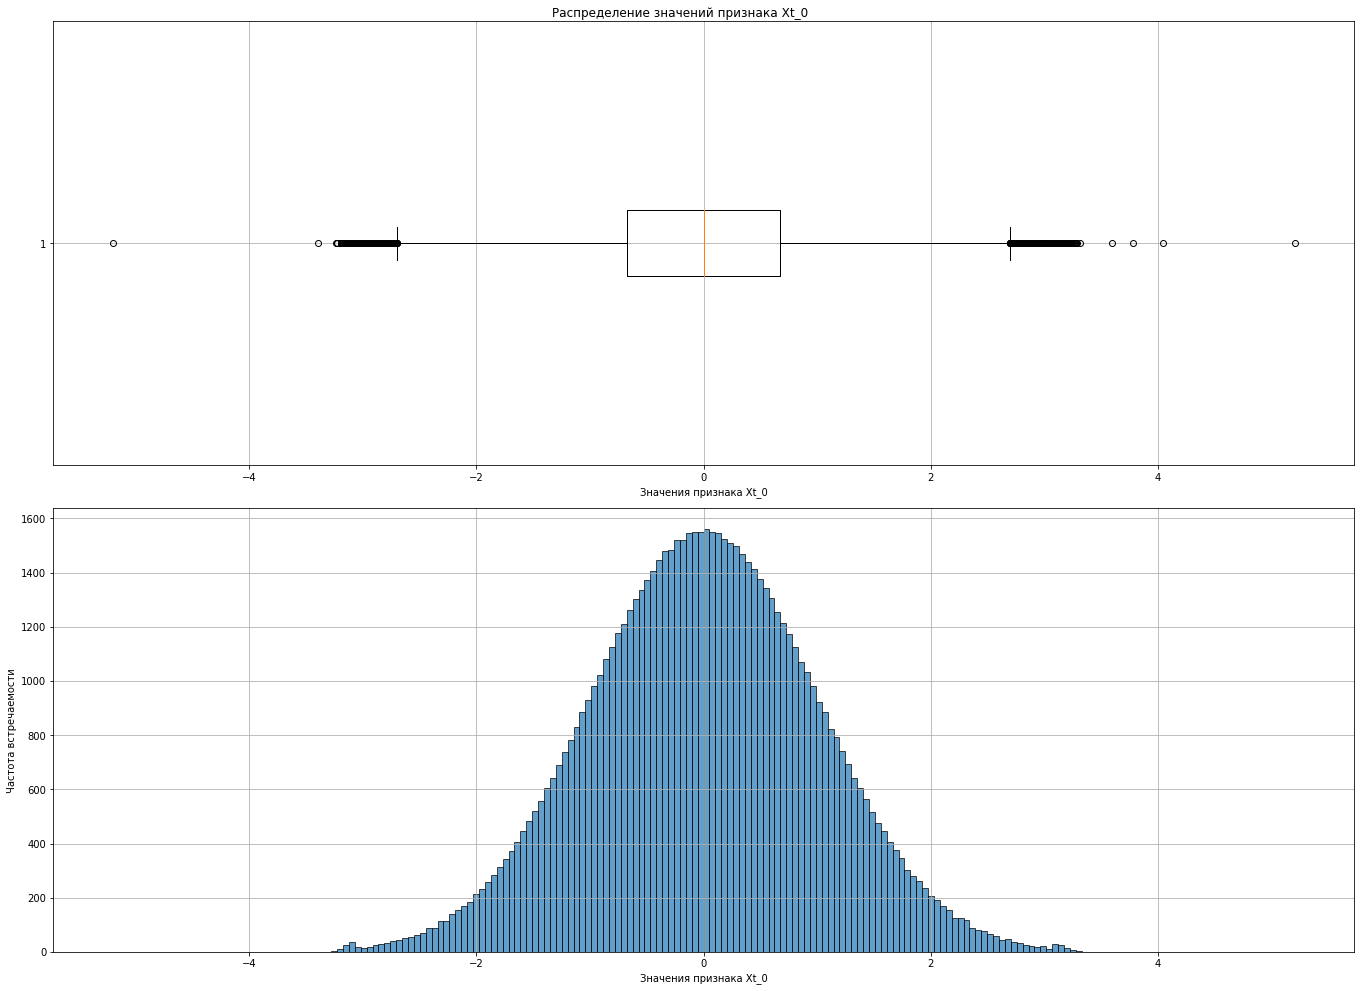



Признак Xt_1 :
count    7.500000e+04
mean     4.140096e-17
std      1.000007e+00
min     -4.208519e+00
25%     -6.783278e-01
50%     -1.865412e-03
75%      6.785798e-01
max      4.590258e+00
Name: Xt_1, dtype: float64


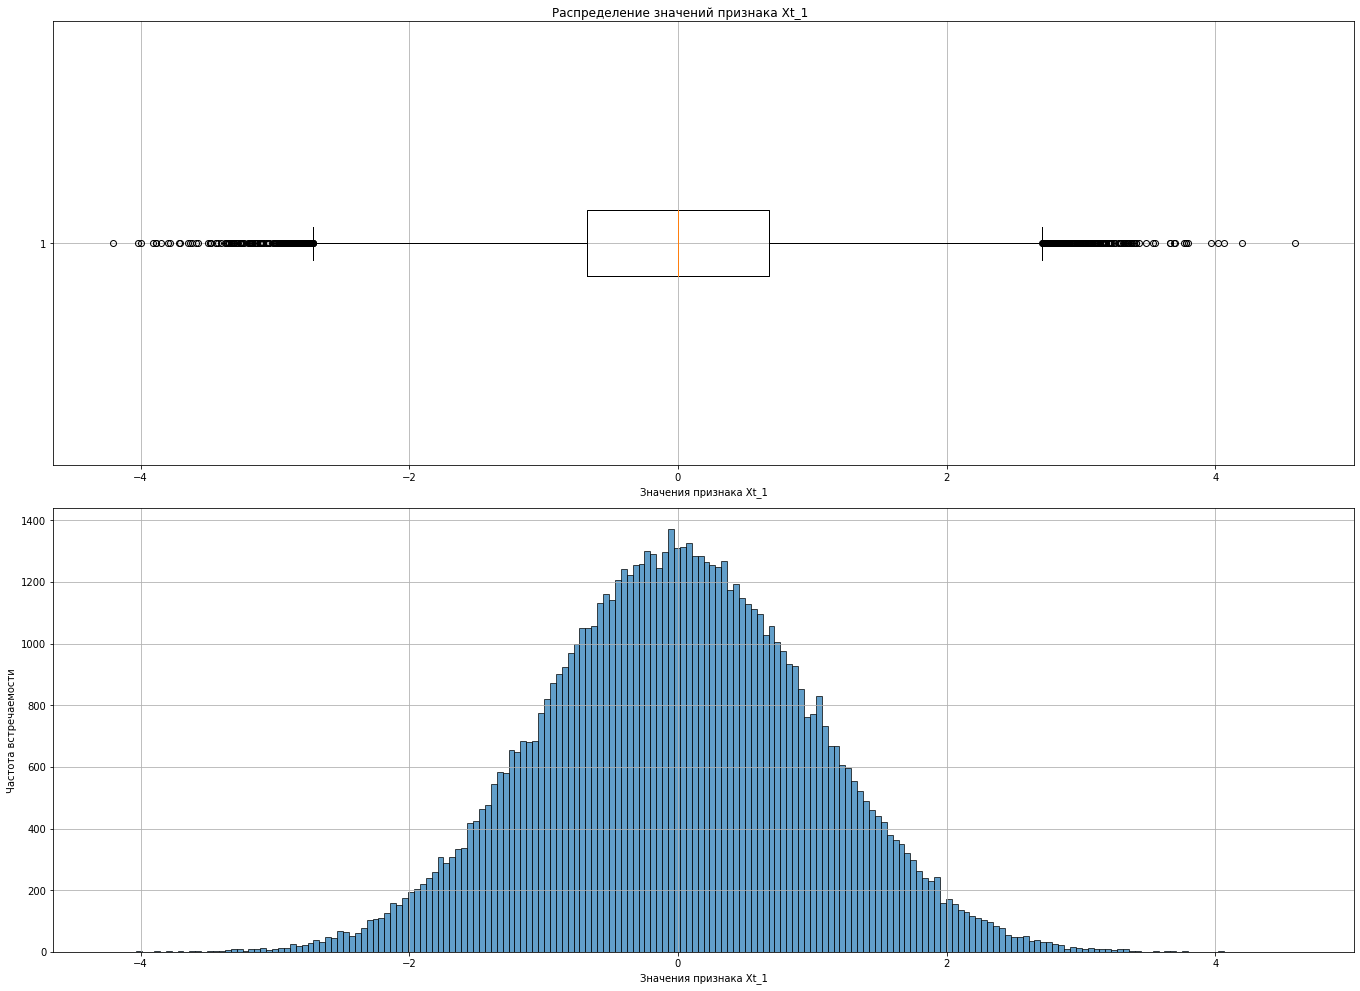



Признак Xt_2 :
count    75000.000000
mean         2.494027
std          1.703581
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max          5.000000
Name: Xt_2, dtype: float64


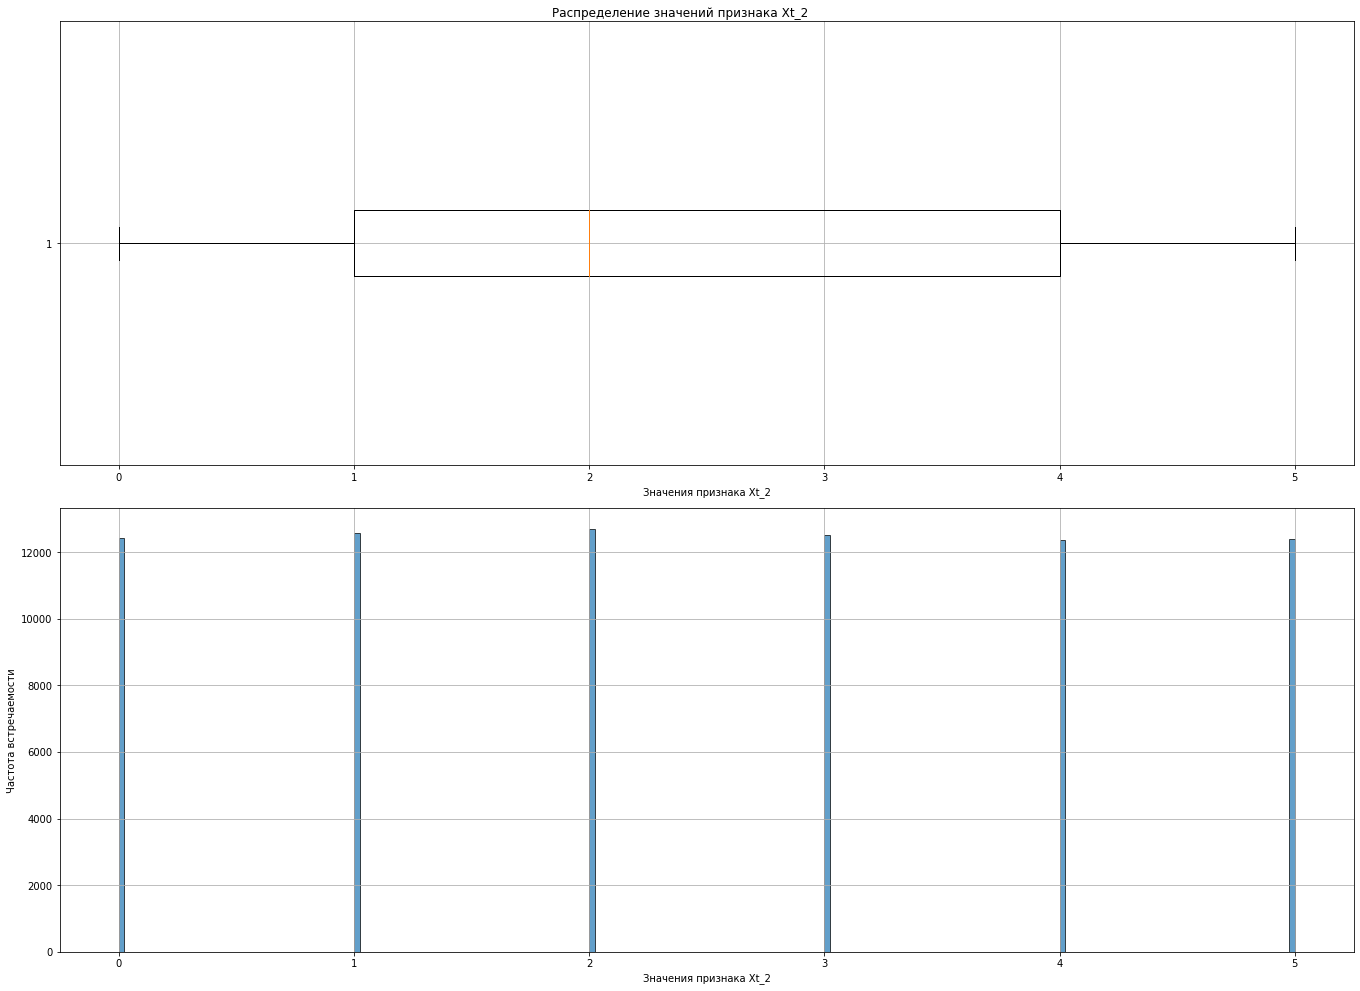

In [61]:
# Создаем пайплайн преобразования данных с заданными шагами и применяем пайплайн к обучающим данным

transorm_train_data(Pipeline(transform_steps), X_train)

Мы проверяем визуально, что после применения соответствующих преобразований к признакам f0 и f1 они стандартизированы и приведены к нормальному распределению с диапазоном значений (-4, 4) и средним значением 0.

Категориальный признак f3 распределен равномерно.

In [62]:
# Создание конвейера, включающего последовательность преобразований признаков и модель
pipeline = Pipeline(transform_steps + [('model', model)])

# Вычисление значения метрики RMSE с использованием кросс-валидации
score = cross_val_score(
    pipeline,  # Модель, включающая преобразования признаков
    X_train,  # Обучающие данные
    Y_train,  # Целевой признак
    cv=10,  # Количество фолдов в кросс-валидации
    scoring=scoring,  # Используемая метрика (RMSE)
)

# Получение обученной модели из конвейера
model_fitted = pipeline.get_params()['model']

In [63]:
# Выводим средний RMSE для всех значений параметра
print('RMSE средняя:', score.mean())

RMSE средняя: -0.9929099991530101


In [64]:
# Делаем предсказания на валидационной выборке
predictions_2 = model_fitted.predict(X_test)

# Копируем целевой признак Y_test, чтобы сохранить оригинальные значения
target_2 = Y_test.copy()

# Выводим метрики модели для валидационной выборки
print_model_metric(target_2, predictions_2)

Средний запас предсказанного сырья: 68.86623810078207
RMSE: 0.8826555346408347


Значения метрик RMSE для рассмотренных моделей практически одинаковы. Однако модель, обученная на стандартизованных признаках, предпочтительнее с точки зрения удобства ее последующего использования.

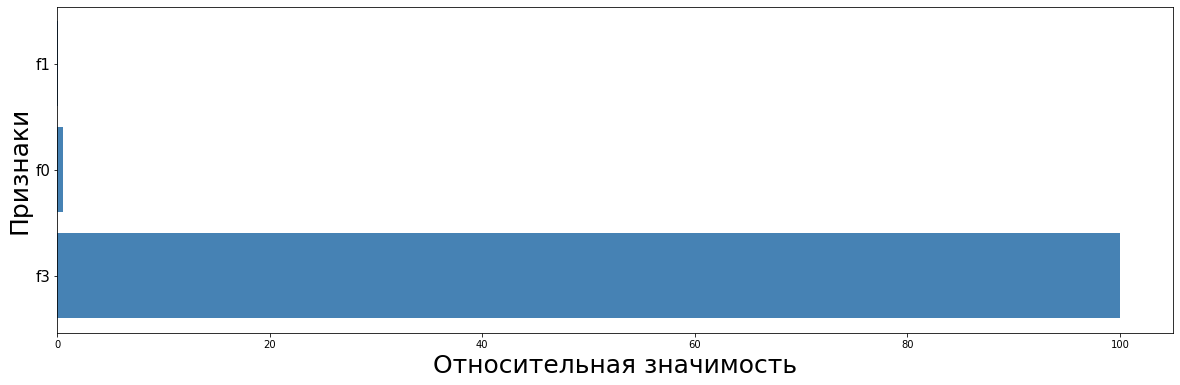

In [65]:
# Выводим важность признаков
print_feature_importance(model_fitted.coef_, ['f0', 'f1', 'f3'])

По аналогии, стоит отметить, что наиболее значимым признаком оказался f3, который является производным от f2. Этот признак также имеет высокое значение коэффициента корреляции с целевым признаком - 0.999.

**Регион №3**

In [66]:
# Разделяем данные на тренировочный и тестовый наборы
X_train, Y_train, X_test, Y_test = def_train_test(region_data_3)

**Обучение модели на исходных признаках**

In [67]:
# Обучение модели на тренировочных данных
model.fit(X_train, Y_train)

# Выполнение предсказаний на валидационной выборке
predictions = model.predict(X_test)

# Вывод метрик качества модели
print_model_metric(Y_test, predictions) 

Средний запас предсказанного сырья: 95.15938113057601
RMSE: 40.0112827625716


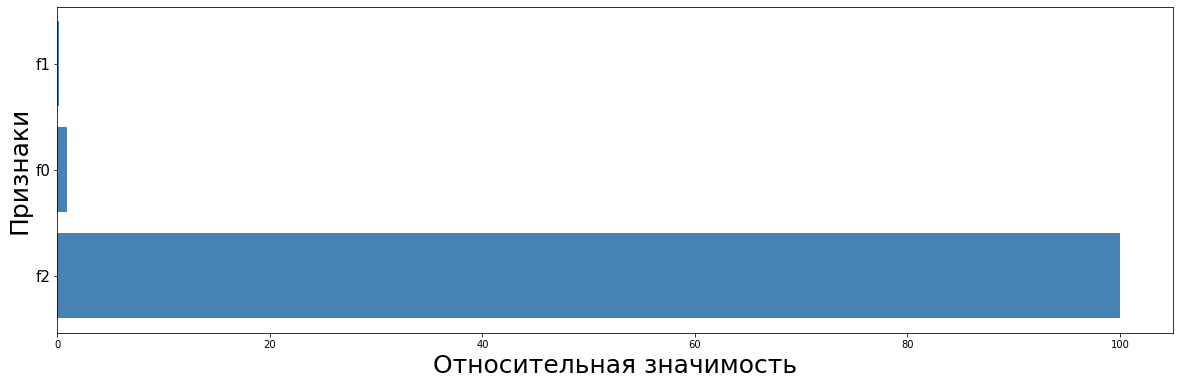

In [68]:
# Вывод важности признаков
print_feature_importance(model.coef_, features)

Исходя из значений коэффициентов корреляции, наиболее важным признаком является f2 на исходных данных. Для дальнейшей оценки значимости признаков, обучим модель на стандартизированных признаках и проанализируем относительную значимость каждого из признаков в модели.

**Обучение модели на признаках после стандартизации**

Выполним стандартизацию признаков путем применения метода StandardScaler ко всем признакам. Это позволит привести распределения признаков к нормальному виду и привести их к общему масштабу области определения.

In [69]:
# Определение шагов трансформации данных
transform_steps = [
    # Шаг "std" - StandardScaler
    ('std', StandardScaler(copy=False, with_mean=True, with_std=True)),
]

,Xt_0,Xt_1,Xt_2
58426,0.139136,0.044678,-0.104825
24359,0.709018,-0.116170,0.432029
20022,0.991742,-0.272057,0.092861
19108,-0.013269,1.025347,-0.022938
56274,0.236535,0.366656,-0.880440




Признак Xt_0 :
count    7.500000e+04
mean     1.733724e-17
std      1.000007e+00
min     -4.298109e+00
25%     -6.726365e-01
50%      4.614029e-03
75%      6.679895e-01
max      4.156779e+00
Name: Xt_0, dtype: float64


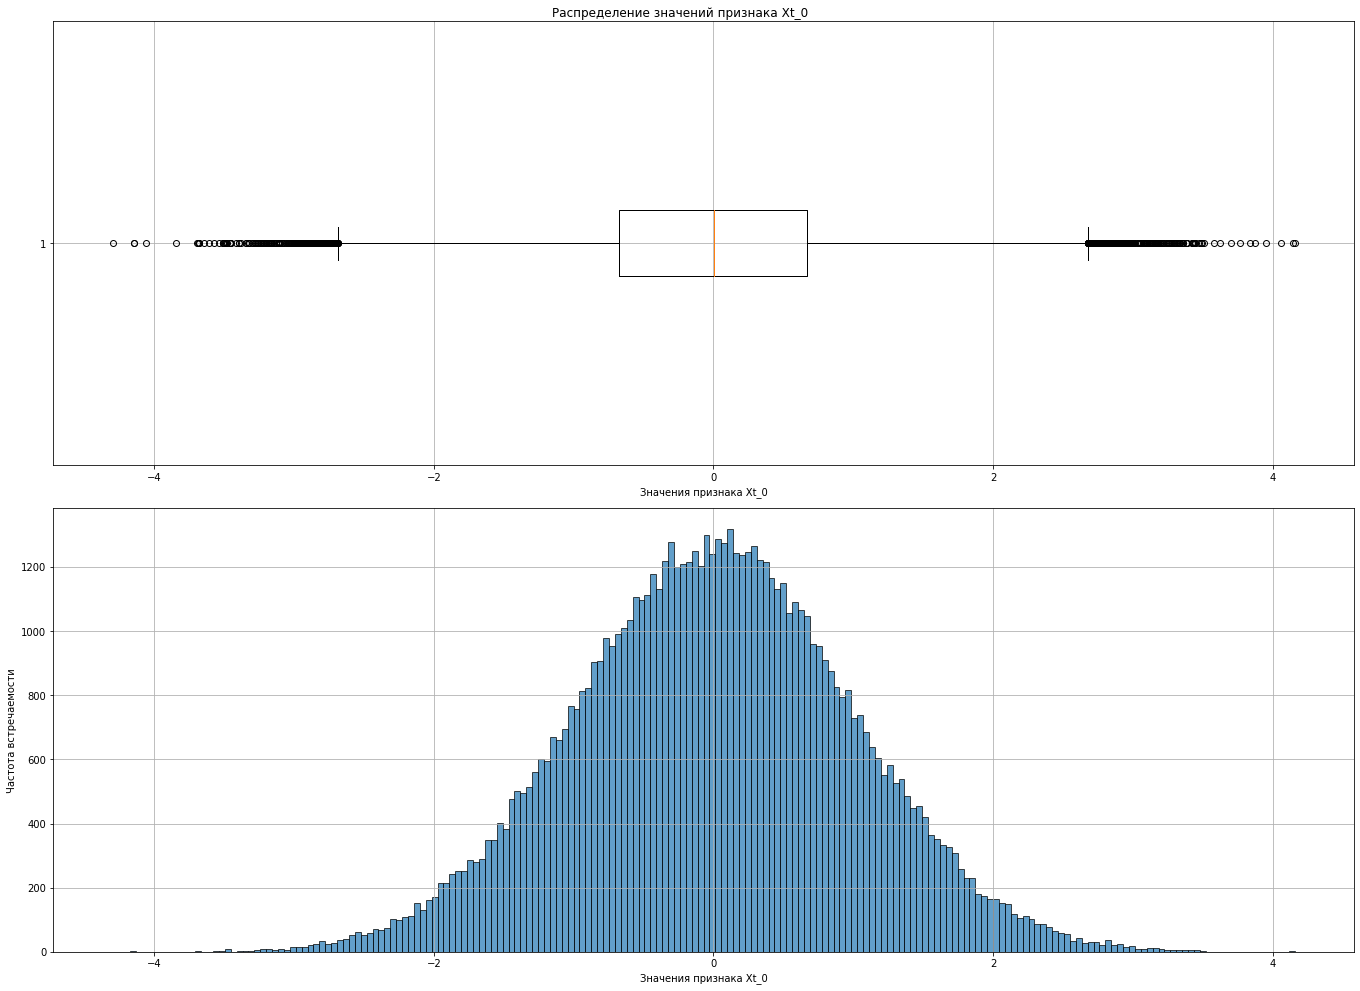



Признак Xt_1 :
count    7.500000e+04
mean     1.250555e-17
std      1.000007e+00
min     -4.106431e+00
25%     -6.780762e-01
50%     -5.310981e-03
75%      6.745886e-01
max      4.548141e+00
Name: Xt_1, dtype: float64


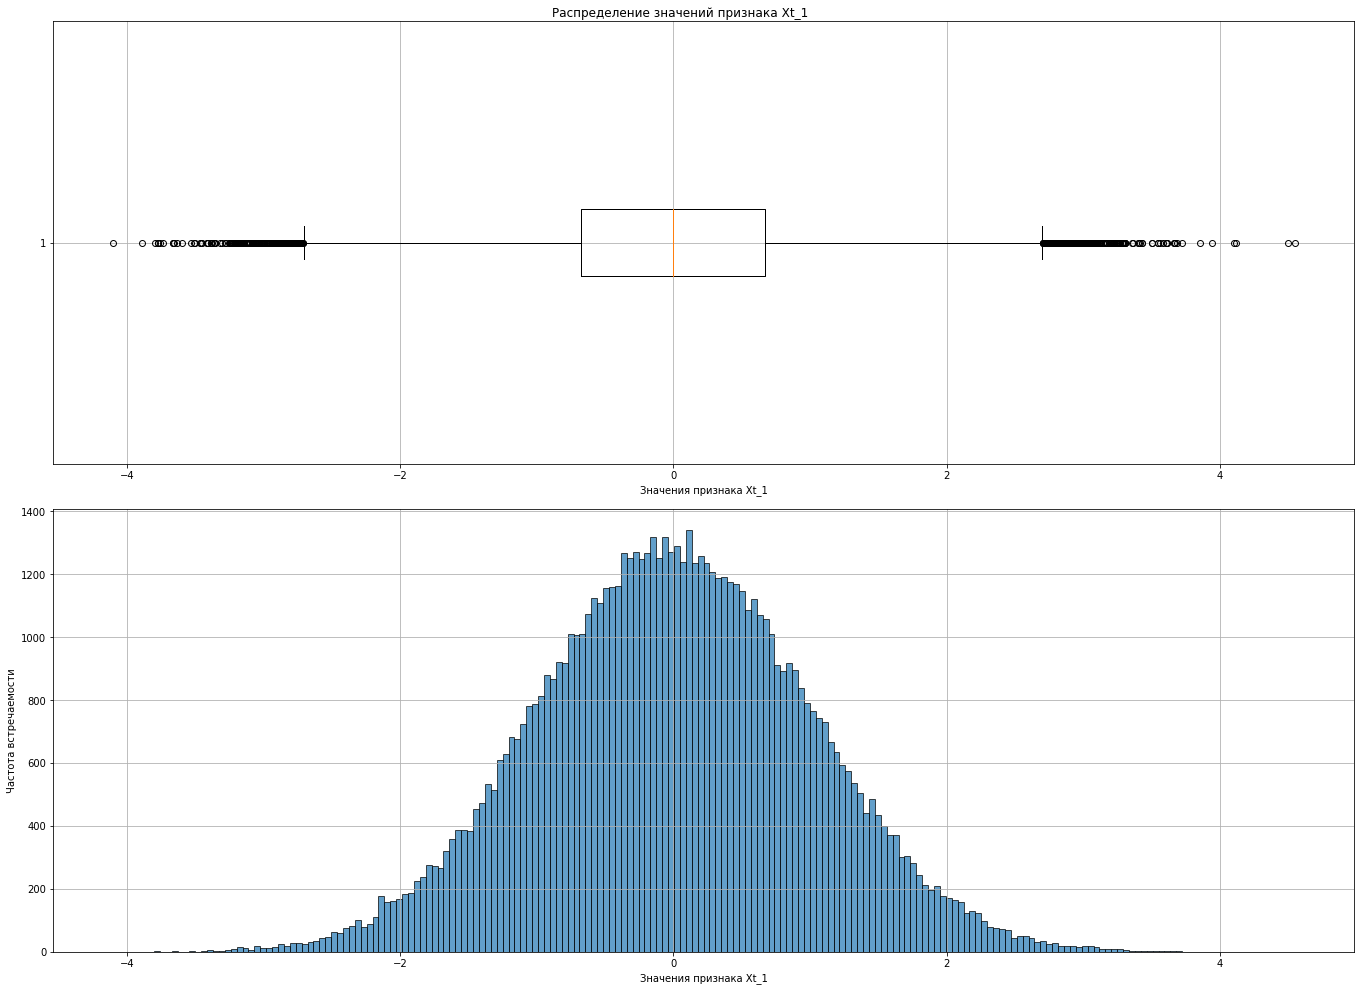



Признак Xt_2 :
count    7.500000e+04
mean    -4.736952e-19
std      1.000007e+00
min     -4.163513e+00
25%     -6.820328e-01
50%     -2.815276e-03
75%      6.807628e-01
max      4.103444e+00
Name: Xt_2, dtype: float64


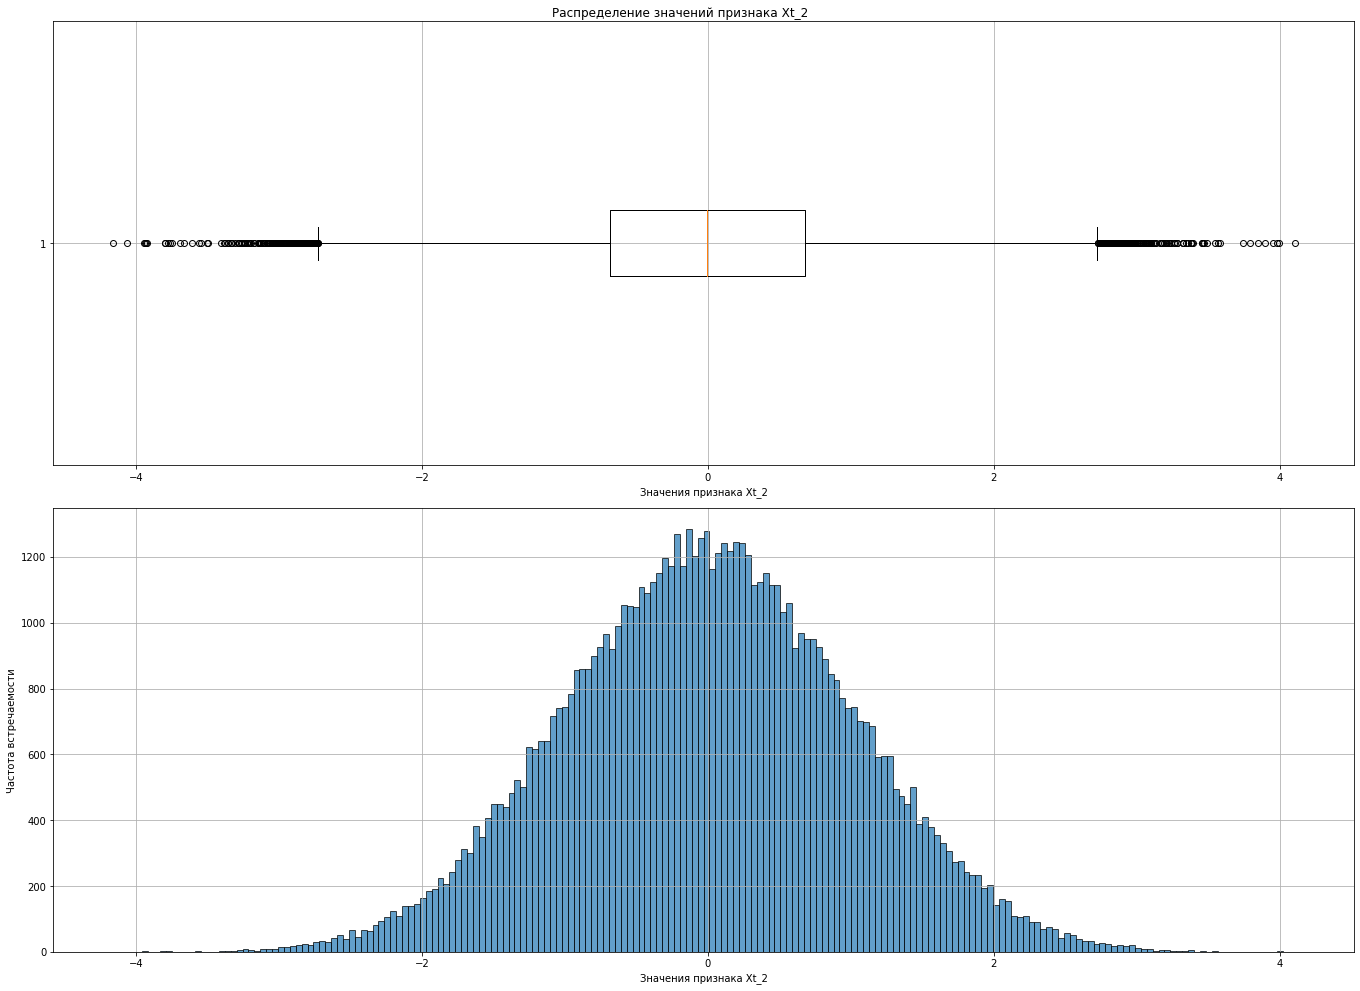

In [70]:
# Создание и применение пайплайна трансформации данных к обучающим данным
transorm_train_data(Pipeline(transform_steps), X_train)

In [71]:
# Создание пайплайна с последовательностью преобразований и моделью
pipeline = Pipeline(transform_steps + [('model', model)])

# Вычисление значений метрики RMSE с помощью кросс-валидации
score = cross_val_score(
    pipeline,  # Пайплайн
    X_train,  # Обучающие признаки
    Y_train,  # Целевой признак
    cv=10,  # Количество фолдов в кросс-валидации
    scoring=scoring,  # Используемая метрика (RMSE)
)

# Получение объекта модели, обученной на полном обучающем наборе данных
model_fitted = pipeline.get_params()['model']

In [72]:
# Выводим среднее значение RMSE из списка

print('RMSE средняя:', score.mean())

RMSE средняя: -40.071503371055584


In [73]:
# Получаем предсказания модели на тестовой выборке
predictions_3 = model_fitted.predict(X_test)
# Создаем копию целевых значений
target_3 = Y_test.copy()

# Выводим средний запас предсказанного сырья и RMSE
print_model_metric(target_3, predictions_3)

Средний запас предсказанного сырья: 95.15938113057601
RMSE: 40.0112827625716


Значения метрик RMSE для всех рассмотренных моделей практически одинаковы. Однако модель, обученная на стандартизованных признаках, предпочтительнее для дальнейшего использования в силу ее удобства и применимости.

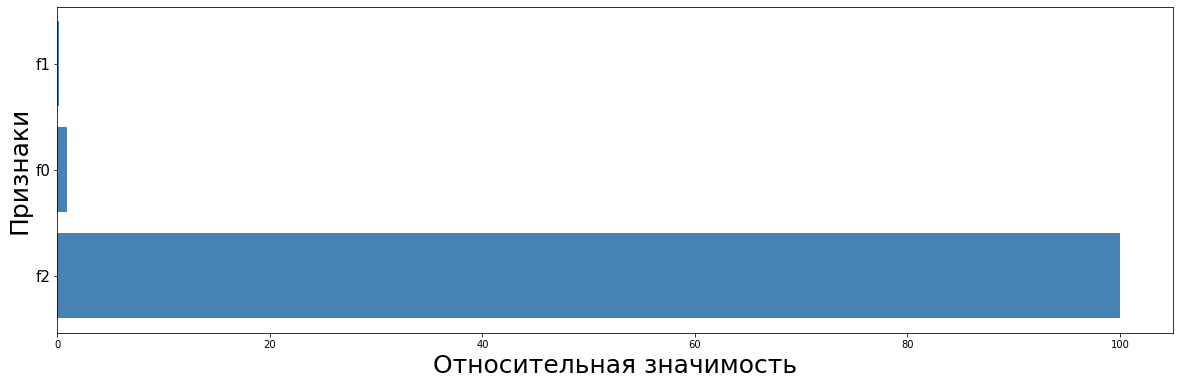

In [74]:
# Выводим важность признаков модели
print_feature_importance(model_fitted.coef_, features)

На стандартизованных признаках также наиболее значимым признаком оказался f2, что соответствует высокой корреляции с целевым признаком. Это подтверждает высокую степень влияния данного признака на оценку ресурсов скважины, аналогично региону №2.

# Выводы

На этапе обучения модели линейной регрессии в каждом из рассматриваемых регионов были выполнены следующие шаги:

- Исходные данные были разделены на обучающую и тестовую выборки в соотношении 75:25.
- Модели были обучены на базовом наборе исходных признаков, а также на стандартизованных признаках. Метрика RMSE для обеих моделей в каждом регионе совпала. Для расчета предсказаний выбраны модели, обученные на стандартизованных признаках, с целью возможного использования в дальнейших исследованиях.
- Для каждого региона были получены значения среднего запаса предсказанного сырья и метрики RMSE:
  - Регион №1: средний объем запасов - 92.5, RMSE - 37.6.
  - Регион №2: средний объем запасов - 68.9, RMSE - 0.9.
  - Регион №3: средний объем запасов - 95.2, RMSE - 40.0.
  
Низкое значение RMSE в регионе №2 объясняется высокой степенью корреляции целевого признака с одним из обучающих признаков.

Наиболее точная оценка среднего объема запасов сырья в скважине получена для региона №2. Однако, абсолютные значения среднего объема запасов выше в регионах №1 и №3 (92.5 и 95.2 соответственно) с соответствующими значениями ошибки (37.6 и 40.0).

Предсказания были сохранены для дальнейшего использования при расчете прибыли и оценке рисков.

## Подготовка к расчёту прибыли

**Подготовка к расчёту прибыли**

В соответствии с изначальными данными, в регионе выделен бюджет в размере 10 миллиардов рублей на разработку скважин.

При текущей цене на нефть в размере 450 рублей за баррель, каждый баррель дает доход в размере 450 тысяч рублей. Учитывая, что объемы скважин указаны в тысячах баррелей, доход с каждой единицы продукта составляет 450 тысяч рублей.

Для разведки региона исследуется 500 точек, и с помощью машинного обучения выбираются 200 лучших точек для последующей разработки.

In [90]:
# Задаем бюджет на разработку месторождения в долларах
well_development_budget = 10 * (10 ** 9)

# Задаем цену одного барреля нефти в долларах
price_of_one_barrel = 450 * (10 ** 3)

# Задаем количество разрабатываемых скважин
development_wells = 200

Согласно исходным данным, для достижения уровня безубыточности разработки в регионе необходимо, чтобы суммарная стоимость добытого сырья из 200 отобранных скважин составляла 10 миллиардов рублей.

Теперь рассчитаем средний объем запасов в каждой скважине, чтобы достичь этого уровня безубыточности.

In [91]:
# Вычисляем точку безубыточности (в объеме добычи нефти) для окупаемости разработки
break_even_vol = round(well_development_budget / (development_wells * price_of_one_barrel), 2)

# Выводим значение точки безубыточности
break_even_vol

111.11

Для достижения уровня безубыточности разработки, средний объем сырья в каждой разрабатываемой скважине должен составлять не менее 111.11 тысяч баррелей. Это значение превышает средний объем сырья в скважинах в целом для каждого из регионов №1, №2 и №3.

Теперь определим функцию, которая будет вычислять общую выручку и прибыль от скважин с наибольшими предсказанными объемами сырья. Функция будет принимать в качестве параметра количество выбранных скважин. Внутри функции мы выберем скважины с наивысшими значениями предсказаний, затем просуммируем целевое значение объема сырья, соответствующее этим предсказаниям, и рассчитаем общую выручку и прибыль.

In [92]:
# функция расчета выручки и прибыли по скважинам с наивысшим значением предсказанного объема сырья 
# возвращает пару значений: общая_выручка, прибыль

def get_revenue_profit(target, predictions, count):
    # Сортируем предсказания по убыванию
    predictions_sorted = predictions.sort_values(by='predicted', ascending=False)
    # Получаем целевые значения для отсортированных предсказаний, ограниченные заданным количеством count
    target_sorted = target.loc[predictions_sorted.index][:count]
    
    # Вычисляем суммарное значение целевого признака (объем сырья) для выбранных скважин
    target_sum = target_sorted['product'].sum()
    
    # Вычисляем общую выручку и прибыль, умножая суммарный объем сырья на цену одного барреля и вычитая бюджет на разработку скважин
    return price_of_one_barrel * target_sum, price_of_one_barrel * target_sum - well_development_budget


## Расчёт прибыли и рисков

Для оценки прибыльности и рисков будет использован метод Bootstrap:

1. Сделаем 1000 случайных выборок, каждая из которых будет содержать 500 пар (предсказанный объем, фактический объем) для каждого из регионов.
2. Для каждой выборки выберем 200 скважин с наибольшими предсказанными объемами сырья и рассчитаем значения общей выручки и прибыли для этих скважин.
3. Соберем все рассчитанные значения общей выручки и прибыли (всего 1000 измерений).
4. На основе совокупности этих значений (1000 измерений) выполним следующие расчеты:
  - Рассчитаем среднюю прибыль.
  - Рассчитаем 95%-й доверительный интервал для прибыли.
  - Определим риск убытков, вычисляя долю измерений, где прибыль меньше или равна нулю.
  
Таким образом, метод Bootstrap позволит нам получить оценку прибыльности и рисков для разработки скважин в каждом из регионов.

In [93]:
# Создаем словарь `region_results`, в котором каждому региону (№1, №2, №3) соответствуют предсказанные и фактические значения
region_results = {
    '№1' : [predictions_1, target_1],  # Для региона №1
    '№2' : [predictions_2, target_2],  # Для региона №2
    '№3' : [predictions_3, target_3],  # Для региона №3
}

In [94]:
# Создаем функцию `format_ruble`, которая форматирует числовое значение в строку с символом рубля и разделением разрядов
def format_ruble(ruble):
    # Используем форматирование строк, чтобы добавить символ рубля (₽), запятые для разделения разрядов и один знак после запятой
    return "\u20BD{:,.1f}".format(ruble)

In [95]:
state = np.random.RandomState(random_state)  # Инициализация генератора случайных чисел с указанным состоянием

hist_revenue = []  # Список для хранения истории значений выручки
hist_profit = []  # Список для хранения истории значений прибыли

# Обход результатов для каждого региона
for region in region_results:
    [predictions, target] = region_results[region]  # Получаем предсказания и целевой признак для текущего региона
    
    # Создаем DataFrame с предсказаниями, задавая названия столбцов и индекс из целевого признака
    df_predictions = pd.DataFrame(predictions, columns=['predicted'], index=target.index)

    print('{0}  Расчет по региону {1}  {0}'.format('*' * 50, region))  # Выводим заголовок для текущего региона
    
    revenue = []  # Список для хранения значений выручки
    profit = []  # Список для хранения значений прибыли
    
    # Проводим 1000 итераций для расчета выручки и прибыли
    for i in range(1000):
        # Получаем случайную подвыборку из целевого признака с замещением
        target_subsample = target.sample(n=500, replace=True, random_state=state)

        # Получаем предсказания только для выбранных индексов
        probs_subsample = df_predictions.loc[target_subsample.index]
        
        # Вычисляем выручку и прибыль для текущей итерации
        revenue_val, profit_val = get_revenue_profit(target_subsample, probs_subsample, development_wells)
        
        # Добавляем значения выручки и прибыли в соответствующие списки
        revenue.append(revenue_val)
        profit.append(profit_val)
        
    revenue = pd.Series(revenue)  # Преобразуем список выручки в Series
    hist_revenue.append(revenue)  # Добавляем Series в список истории выручки
    
    profit = pd.Series(profit)  # Преобразуем список прибыли в Series
    hist_profit.append(profit)  # Добавляем Series в список истории прибыли
    
    # Вычисляем статистики и выводим результаты для текущего региона
    lower = profit.quantile(0.025)  # 2.5%-квантиль прибыли
    high = profit.quantile(0.975)  # 97.5%-квантиль прибыли

    revenue_mean = revenue.mean()  # Средняя выручка
    profit_mean = profit.mean()  # Средняя прибыль
    
    # Выводим результаты расчета
    print("Средняя прибыль: ", format_ruble(profit_mean))
    print("2.5%-квантиль: ", format_ruble(lower))
    print("95%-й доверительный интервал: ({0}, {1})".format(format_ruble(lower), format_ruble(high)))
    print("Вероятность убытка:", (profit <= 0).mean() * 100)
    print('\n')

**************************************************  Расчет по региону №1  **************************************************
Средняя прибыль:  ₽444,029,582.7
2.5%-квантиль:  ₽-55,466,563.4
95%-й доверительный интервал: (₽-55,466,563.4, ₽944,833,568.8)
Вероятность убытка: 4.2


**************************************************  Расчет по региону №2  **************************************************
Средняя прибыль:  ₽494,015,304.9
2.5%-квантиль:  ₽93,023,865.6
95%-й доверительный интервал: (₽93,023,865.6, ₽892,870,180.0)
Вероятность убытка: 1.0


**************************************************  Расчет по региону №3  **************************************************
Средняя прибыль:  ₽393,152,874.7
2.5%-квантиль:  ₽-125,216,753.8
95%-й доверительный интервал: (₽-125,216,753.8, ₽944,875,961.6)
Вероятность убытка: 7.7




Визуализируем полученные значения средней прибыли. Вертикальной красной чертой обозначим границу безубыточности (нулевая прибыль)

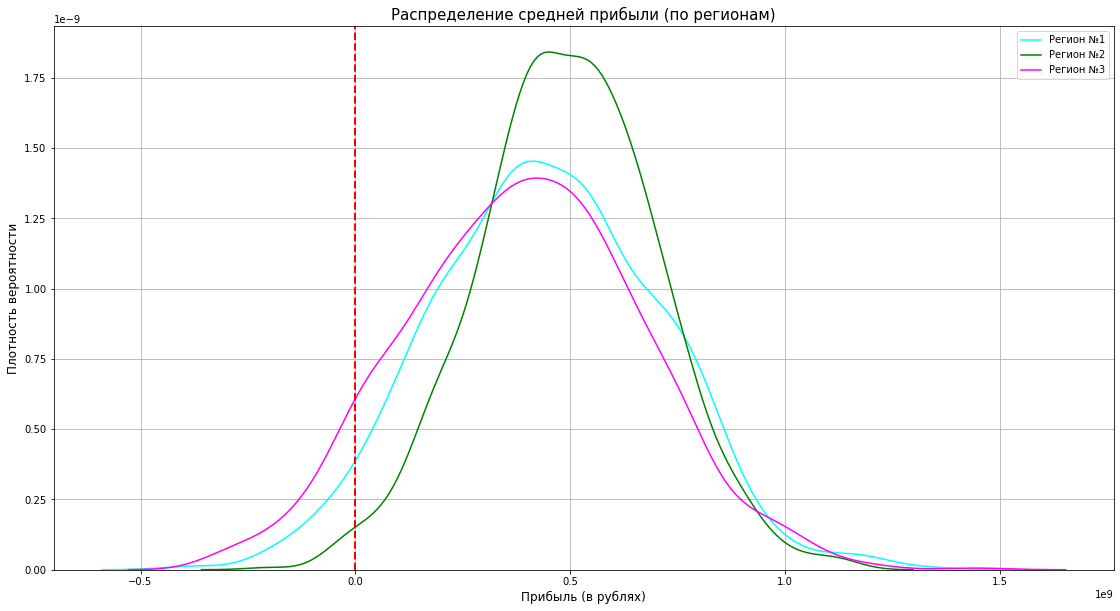

In [97]:
# Задаем метки групп и цвета для каждого региона
group_labels = ['Регион №1', 'Регион №2', 'Регион №3']
colors = ['cyan', 'green', 'magenta']

# Создаем новую фигуру с указанным размером
plt.figure(figsize=(19, 10))

# Создаем графики ядерной оценки плотности для каждого региона
for i, hist in enumerate(hist_profit):
    sns.kdeplot(hist, color=colors[i], label=group_labels[i])

# Добавляем заголовок, подписи к осям и легенду
plt.title('Распределение средней прибыли (по регионам)', fontsize=15)
plt.xlabel('Прибыль (в рублях)', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.legend()

# Рисуем вертикальную линию черного цвета для отметки нулевой прибыли
plt.axvline(0, color='red', linestyle='--', linewidth=2)

# Включаем сетку на графике
plt.grid(True)

# Отображаем график
plt.show()

Распределение средней прибыли в регионе №2 обладает наименьшим разбросом вокруг среднего значения. Вероятность убытков в регионе №2 составляет 1.0%, в то время как в регионах №1 и №3 эта вероятность значительно выше, составляя 4.2% и 7.7% соответственно.

**Выводы**

На этапе оценки рисков и прибыли были выполнены следующие шаги:

1. Определены основные параметры для проведения расчетов, включая себестоимость добычи, цену барреля и количество скважин для разработки.
2. Рассчитан средний объем сырья в разрабатываемой скважине, необходимый для достижения безубыточности. Это значение (не менее 111.11 тысяч баррелей) превышает средний объем сырья в общей выборке по каждому из трех регионов.
3. Создана функция для расчета общей выручки и прибыли на основе предсказанных и фактических объемов запасов.
4. Применена техника Bootstrap для оценки прибыльности и рисков разработки. В результате:
  - Регион №2 оказался единственным с вероятностью убытков менее 2.5%.
  - Регион №2 также имеет наивысшее среднее значение прибыли от разработки скважин - более 494 млн рублей.
  - Доверительный интервал (95%) для средней прибыли в регионе №2 составляет от 93 до 893 млн рублей.
  
Таким образом, несмотря на наименьший средний объем предсказанного сырья, регион №2 является единственным подходящим для разработки скважин, так как обладает наиболее низкой вероятностью убытков (менее 2.5%).

# Выводы

В рамках исследования проведена оценка предоставленных данных о скважинах в трех регионах с целью определения наиболее перспективного региона для добычи нефти. Были выполнены следующие шаги:

**1. Предварительная обработка и оценка данных:**

  - Проверка соответствия загруженных данных предоставленному описанию и определение обучающих и целевых признаков.
  - Оценка распределения значений обучающих атрибутов и корреляций между ними. Установлено, что каждый набор признаков рассматривается в рамках своего региона, без связей с другими регионами, и мультиколлинеарность признаков отсутствует.
  
  
**2. Обучение моделей линейной регрессии для каждого региона:**

  - Разделение исходных данных на обучающую и тестовую выборки в соотношении 75:25.
  - Обучение моделей на базовом и стандартизованном наборах исходных признаков. Метрика RMSE для моделей, построенных на стандартизованных признаках, совпадает для всех регионов.
  - Получены значения среднего объема предсказанного сырья и метрики RMSE для каждого региона.
  
  
**3. Подготовка параметров для оценки рисков и прибыли:**

  - Определение основных параметров, необходимых для расчетов: себестоимости добычи, цены барреля и количества скважин для разработки.
  - Определение среднего объема сырья в разрабатываемой скважине для достижения безубыточности (более 111.11 тысяч баррелей), превышающего средние значения сырья в регионах.
  
  
**4. Оценка прибыльности разработки с помощью техники Bootstrap:**

  - Применение Bootstrap для оценки 1000 случайных выборок и определения прибыли по 200 скважинам с наибольшими предсказанными объемами сырья.
  - Определение региона №2 как единственного с вероятностью убытков меньше 2.5% и наибольшей средней прибылью разработки скважин (более 494 млн рублей).
  - Установление 95% доверительного интервала для средней прибыли в регионе №2: от 93 до 893 млн рублей.
  
В итоге, несмотря на наименьшее значение среднего запаса предсказанного сырья, регион №2 является единственным подходящим для дальнейшей разработки скважин с учетом всех рассмотренных параметров. Компания "ГлавРосГосНефть" может ожидать прибыль в диапазоне от 93 до 893 млн рублей при разработке скважин в этом регионе. Оценка рисков и прибыли, а также использование модели машинного обучения позволяют принять обоснованное решение о выборе региона №2 для добычи нефти.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Выполнен шаг 1: данные подготовлены
- [X]  Выполнен шаг 2: модели обучены и проверены
    - [X]  Данные корректно разбиты на обучающую и валидационную выборки
    - [X]  Модели обучены, предсказания сделаны
    - [X]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [X]  На экране напечатаны результаты
    - [X]  Сделаны выводы
- [X]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [X]  Для всех ключевых значений созданы константы Python
    - [X]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [X]  По предыдущему пункту сделаны выводы
    - [X]  Написана функция расчёта прибыли
- [X]  Выполнен шаг 4: посчитаны риски и прибыль
    - [X]  Проведена процедура *Bootstrap*
    - [X]  Все параметры бутстрепа соответствуют условию
    - [X]  Найдены все нужные величины
    - [X]  Предложен регион для разработки месторождения
    - [X]  Выбор региона обоснован